# Stage 3: Analysis

___The last stage, which is a culmination of the previous two, concentrated on analyzing the accumulated dataset. This dataset, consisting of both organizational factors and the classification results, was subjected to analysis to assess to what extent the organizational factors are associated with the disclosure of the five GDPR privacy policy core requirements.___ - Section 4.3.

This script conducts analysis on a combined data set that includes organizational factors and classification results with regards to five GDPR privacy policy core requirements.

---

# Features

## Understanding the data
#### (Initial) Selected columns
|iloc| Column | Explanation | Non-Null Count | Dtype|
|:---|:---|:---|:---|:---|
|0 | Company name Latin alphabet |                      |5063 non-null| object |
|1 | Inactive |                                         |5063 non-null| boolean|
|2 | Quoted | Publicly quoted companies                 |5063 non-null| boolean|
|3 | Country ISO code |                                 |5052 non-null| categorical |
|4 | NACE Rev. 2, core code (4 digits) |                |4953 non-null| categorical |
|5 | Last avail. year |                                 |4915 non-null| int |
|6 | Operating revenue (Turnover) EUR Last avail. yr | |5052 non-null| float |
|7 | Number of employees Last avail. yr|               |5061 non-null| int |
|8 | Size classification |                             |5063 non-null|categorical|
|9 | DPO |                                             |5063 non-null| boolean|
|10 | Purpose|                                          |5063 non-null| boolean|
|11 | Acquired data    |                                |5063 non-null| boolean|
|12 | Data sharing |                                    |5063 non-null| boolean|
|13 | Rights     |                                      |5063 non-null| boolean|


## Company Size Classification
We distinguish between SMEs and LEs, thus combining the categories of small companies and Medium sized companies on the one side, and combining Large companies and Very large companies on the other. 
__General remark: the criteria for a company to be included in one of the categories below are always based on values expressed in EUR (values in USD are given for information purposes only and may vary depending on current exchange rate).__

### Very large companies (VL)
Companies on Orbis Europe are considered to be very large when they match at least one of the following conditions:

- Operating revenue >= 100 million EUR (130 million USD)
- Total assets >= 200 million EUR (260 million USD)
- Employees >= 1,000
- Listed

Notes:
Companies with ratios operating revenue per employee or total assets per employee below 100 EUR (130 USD) are excluded from this category.
Companies for which operating revenue, total assets and employees are unknown but have a level of capital over 5 million EUR (6.5 million USD) are also included in the category.

### Large companies (L)
Companies on Orbis Europe are considered to be large when they match at least one of the following conditions:

- Operating revenue >= 10 million EUR (13 million USD)
- Total assets >= 20 million EUR (26 million USD)
- Employees >= 150
- Not very large

Notes:
Companies with ratios operating revenue per employee or total assets per employee below 100 EUR (130 USD) are excluded from this category.
Companies for which operating revenue, total assets and employees are unknown but have a level of capital comprised between 500 thousand EUR (650 thousand USD) and 5 million EUR (6.5 million USD) are also included in the category.

### Medium sized companies (M)
Companies on Orbis Europe are considered to be medium sized when they match at least one of the following conditions:

- Operating revenue >= 1 million EUR (1.3 million USD)
- Total assets >= 2 million EUR (2.6 million USD)
- Employees >= 15
- Not very large or large

Notes:
Companies with ratios operating revenue per employee or total assets per employee below 100 EUR (130 USD) are excluded from this category.
Companies for which operating revenue, total assets and employees are unknown but have a level of capital comprised between 50 thousand EUR (65 thousand USD) and 500 thousand EUR (650 thousand USD) are also included in the category.

### Small companies (S)
Companies on Orbis Europe are considered to be small when they are not included in another category.

Source: https://help.bvdinfo.com/LearningZone/Products/orbis4europe/Content/I_Data/Company/SizeClassification.htm?cshid=11001

---
## Industry
_The acronym NACE (Nomenclature of Economic Activities) designates the integrated classification system for products and economic activities. It designates the various statistical nomenclatures of economic activities developed since 1970 in the European Union. The NACE codes are a European Industry-standard classification system similar in function to Standard Industry Classification (SIC) and North American Industry Classification System (NAICS) for classifying business activities._ 

NACE consists of a hierarchical structure (as established in the NACE Regulation), the introductory guidelines and
the explanatory notes. The structure of NACE is described in the NACE Regulation as follows:
- a first level consisting of headings identified by an alphabetical code (sections),
- a second level consisting of headings identified by a two-digit numerical code (divisions),
- a third level consisting of headings identified by a three-digit numerical code (groups),
- a fourth level consisting of headings identified by a four-digit numerical code (classes).

Source: https://ec.europa.eu/eurostat/documents/3859598/5902521/KS-RA-07-015-EN.PDF

### NACE rev. 2 (21)
A) Agriculture, Forestry and Fishing

B) Mining and Quarrying

C) Manufacturing

D) Electricity, Gas, Steam and Air Conditioning Supply

E) Water Supply; Sewerage, Waste Management and Remediation Activities

F) Construction

G) Wholesale and Retail Trade; Repair of Motor Vehicles and Motorcycles

H) Transportation and Storage

I) Accommodation and Food Service Activities

J) Information and Communication

K) Financial and Insurance Activities

L) Real Estate Activities

M) Professional, Scientific and Technical Activities

N) Administrative and Support Service Activities

O) Public Administration and Defence; Compulsory Social Security

P) Education

Q) Human Health and Social Work Activities

R) Arts, Entertainment and Recreation

S) Other Service Activities

T) Activities of Households as Employers; Undifferentiated Goods and Services Producing Activities of Households for Own Use

U) Activities of Extraterritorial Organisations and Bodies

Source:
- https://connects.world/nace-codes/
- https://help.bvdinfo.com/LearningZone/Products/orbis4.1/Content/I_Data/Industry/NACE_REV2.htm?TocPath=Advanced%20search|Data|Industry|_____16
- https://ec.europa.eu/eurostat/documents/3859598/5902521/KS-RA-07-015-EN.PDF (p. 47)

---
## Country
__European Union (27):__ 
Includes Austria, Belgium, Bulgaria, Croatia, Cyprus, Czech Republic, Denmark, Estonia, Finland, France, Germany, Greece, Hungary, Ireland, Italy, Latvia, Lithuania, Luxembourg, Malta, Netherlands, Poland, Portugal, Romania, Slovakia, Slovenia, Spain, and Sweden.

---

### Libraries

In [1]:
import pandas as pd
import numpy as np
from stdnum.eu import nace
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tabulate import tabulate
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

# Datasets

In [2]:
le_classified = pd.read_csv('data/classified/LE_classified.csv', sep='\t', encoding='utf-8')
sme_classified = pd.read_csv('data/classified/SME_classified.csv', sep='\t', encoding='utf-8')
sme4_classified = pd.read_csv('data/classified/SME2_classified.csv', sep='\t', encoding='utf-8')
sme5_classified = pd.read_csv('data/classified/SME3_classified.csv', sep='\t', encoding='utf-8')

In [3]:
# Rename some column headers for consistency
sme_classified.rename(columns={'Operating revenue (Turnover)\nEUR Last avail. yr': 'Operating revenue (Turnover)\nth EUR Last avail. yr'}, inplace=True)
le_classified.rename(columns={'Operating revenue (Turnover)\nEUR Last avail. yr': 'Operating revenue (Turnover)\nth EUR Last avail. yr'}, inplace=True)

### Combine datasets into one dataframe

In [4]:
df_total = pd.concat([le_classified, sme_classified, sme4_classified, sme5_classified], ignore_index=True)

In [5]:
print(df_total.shape)

(10056, 27)


In [6]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10056 entries, 0 to 10055
Data columns (total 27 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Company name Latin alphabet                         10056 non-null  object 
 1   Inactive                                            10056 non-null  object 
 2   Quoted                                              10056 non-null  object 
 3   Branch                                              10056 non-null  object 
 4   OwnData                                             10056 non-null  object 
 5   Woco                                                10056 non-null  object 
 6   Country ISO code                                    9937 non-null   object 
 7   NACE Rev. 2, core code (4 digits)                   9767 non-null   float64
 8   Consolidation code                                  9937 non-null   object 


## Preprocessing
- drop irrelevant columns (feature selection)
- rename columns
- cast NACE values to high-level description
- add column for the calculated years-since-today values
- replace n.a. and missing values
- cast rows to proper object-type

### Drop irrelevant columns

In [7]:
drop_column_names = ['NAICS 2017, core code (4 digits)', 'NAICS 2017, core code - description', 'NAICS 2017, primary code(s)',
                  'NAICS 2017, primary code(s) - description', 'NAICS 2017, secondary code(s) - description',
                  'NAICS 2017, secondary code(s) - description.1', 'Additional address(es) - Country ISO code',
                  'Additional address(es) - Country', 'Additional address(es) - Standardized city', 'Branch', 'OwnData', 'Woco',
                  'Consolidation code', 'Additional address(es) - Standardized city', 'Inactive']

In [8]:
df_total = df_total.drop(columns=drop_column_names)

In [9]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10056 entries, 0 to 10055
Data columns (total 13 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Company name Latin alphabet                         10056 non-null  object 
 1   Quoted                                              10056 non-null  object 
 2   Country ISO code                                    9937 non-null   object 
 3   NACE Rev. 2, core code (4 digits)                   9767 non-null   float64
 4   Last avail. year                                    9800 non-null   float64
 5   Operating revenue (Turnover)
th EUR Last avail. yr  9937 non-null   object 
 6   Number of employees
Last avail. yr                  10047 non-null  object 
 7   Size classification                                 10056 non-null  object 
 8   DPO                                                 10056 non-null  int64  


### Rename columns

In [10]:
df_total.rename(columns={"Company name Latin alphabet":"Company name",
                                 "Number of employees\nLast avail. yr":"Number of employees (LAY)", 
                                 "Operating revenue (Turnover)\nth EUR Last avail. yr":"Operating revenue EU (Turnover LAY)",
                                 "Last avail. year":"Last avail. year (LAY)",
                                 "NACE Rev. 2, core code (4 digits)":"NACE2 (4 digits)"}, 
                     inplace = True)

In [11]:
# print(df_total['Quoted'].value_counts())
(df_total.head(3))

Company name Quoted Country ISO code  NACE2 (4 digits)  \
0  KAUTH HOLDING GMBH & CO. KG     No               DE            6420.0   
1      APERAM STAINLESS EUROPE     No               FR            4612.0   
2      ZYLAB TECHNOLOGIES B.V.     No               NL            6202.0   

   Last avail. year (LAY) Operating revenue EU (Turnover LAY)  \
0                  2018.0                        121062255.27   
1                  2019.0                          2425755806   
2                  2019.0                                n.a.   

  Number of employees (LAY)          Size classification  DPO  Purpose  \
0                       515  Large or Very large company    1        1   
1                      n.a.  Large or Very large company    1        1   
2                        54  Large or Very large company    0        1   

   Acquired data  Data sharing  Rights  
0              1             1       1  
1              0             0       1  
2              1             1       0

### Cast NACE values to higher abstraction level
Sources:
- https://arthurdejong.org/python-stdnum/doc/1.14/stdnum.eu.nace
- https://ec.europa.eu/eurostat/ramon/nomenclatures/index.cfm?TargetUrl=LST_NOM_DTL&StrNom=NACE_REV2&StrLanguageCode=EN&IntPcKey=&StrLayoutCode=HIERARCHIC&IntCurrentPage=1
- https://connects.world/nace-codes/
- https://ec.europa.eu/competition/mergers/cases/index/nace_all.html

In [12]:
# nace.get_label('05')
# le_classified["NACE Rev. 2, core code (4 digits)"] = le_classified["NACE Rev. 2, core code (4 digits)"].astype('int', errors='ignore')
nace2 = df_total["NACE2 (4 digits)"].tolist()

In [13]:
# using stdnum lib from: https://pypi.org/project/python-stdnum/

def get_nace2_label_2(code):
    if math.isnan(float(code)):
        return code;
    else:
        if(len(str(int(float(code)))) == 3):
            code = "0" + str(code)
                    
        code_str = str(code)[0:2]
        return nace.get_label(code_str)
    
def get_nace2_label(code):
    if math.isnan(float(code)):
        return code;
    else:
        if(len(str(int(float(code)))) == 3):
            code = "0" + str(code)
                    
        code_str = str(code)[0:2]
        nace_label = nace.get_label(list(nace.info(code_str).values())[0])
        return nace_label

In [14]:
nace2_clean = [get_nace2_label(float(code)) for code in nace2]

In [15]:
len(nace2_clean)

10056

##### Add column for NACE2 first-level classification

In [16]:
# le_classified = le_classified.drop('NACE2', 1)
df_total.insert(4,'NACE2', nace2_clean)
df_total = df_total.drop('NACE2 (4 digits)', axis=1)
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10056 entries, 0 to 10055
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Company name                         10056 non-null  object 
 1   Quoted                               10056 non-null  object 
 2   Country ISO code                     9937 non-null   object 
 3   NACE2                                9767 non-null   object 
 4   Last avail. year (LAY)               9800 non-null   float64
 5   Operating revenue EU (Turnover LAY)  9937 non-null   object 
 6   Number of employees (LAY)            10047 non-null  object 
 7   Size classification                  10056 non-null  object 
 8   DPO                                  10056 non-null  int64  
 9   Purpose                              10056 non-null  int64  
 10  Acquired data                        10056 non-null  int64  
 11  Data sharing                

### Years-since-today values
Only include organizations of which the data is relevant to the GDPR, i.e., updated within the last 3 years (since 1 december 2021).

In [17]:
LAY = df_total["Last avail. year (LAY)"].tolist()

In [18]:
# now = datetime.datetime.now()
now = datetime.datetime(2021, 12, 1)

In [19]:
now.year
# LAY = [int(el) if el != np.nan for el in LAY]
# YST = [(now.year - int(year)) if year is not math.isnan(year) else year for year in LAY]
YST = []
for year in LAY:
    if math.isnan(year):
        YST.append(year)
    else:
        YST.append(now.year - int(year))

In [20]:
YST

[3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 nan,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 2,
 17,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 nan,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 11,
 6,
 2,
 3,
 7,
 2,
 3,
 2,
 2,
 6,
 2,
 22,
 2,
 3,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 18,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 4,
 2,
 2,
 nan,
 2,
 2,
 8,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 15,
 4,
 3,
 9,
 1,
 3,
 2,
 13,
 17,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 1,
 5,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 17,
 2,
 2,
 2,
 2,
 2,
 2,
 12,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 nan,
 13,
 2,
 2,
 1,
 nan,
 3,
 2,
 1,
 2,
 4,
 2,
 2,
 4,
 5,
 1,
 2,
 2,
 15,
 2,
 3,
 2,
 2,
 2,
 3,
 3,
 2,
 2,
 2,
 2,
 5,
 2,
 2,
 3,
 2,
 4,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 nan,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 5,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 

In [21]:
# insert in dataframe
df_total.insert(5,'Years since today', YST)

In [22]:
df_total['Years since today'].value_counts()

2.0     6129
1.0     1762
3.0      653
4.0      208
5.0      107
6.0       74
7.0       71
0.0       70
12.0      67
17.0      64
15.0      63
14.0      61
8.0       60
16.0      60
13.0      54
11.0      49
19.0      47
10.0      44
9.0       43
18.0      35
20.0      24
21.0      20
22.0      10
25.0       4
24.0       4
28.0       3
26.0       3
33.0       2
30.0       2
29.0       2
23.0       2
31.0       1
34.0       1
36.0       1
Name: Years since today, dtype: int64

In [23]:
df_total = df_total[df_total['Years since today'] < 4]

In [24]:
df_total = df_total.drop("Last avail. year (LAY)", axis=1)

In [25]:
df_total.tail(3)

Company name Quoted Country ISO code  \
10053                                   ZANOLA S.R.L.     No               IT   
10054  BROWNHOUSE FRA LAN AIRPORT HOTEL GMBH & CO. KG     No               DE   
10055                                   HOME DECOR OU     No               EE   

                                                   NACE2  Years since today  \
10053                                      MANUFACTURING                1.0   
10054          ACCOMMODATION AND FOOD SERVICE ACTIVITIES                2.0   
10055  WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VE...                1.0   

      Operating revenue EU (Turnover LAY) Number of employees (LAY)  \
10053                            2677.177                        33   
10054                              2000.0                        40   
10055                            2350.705                         5   

      Size classification  DPO  Purpose  Acquired data  Data sharing  Rights  
10053                 SME    0        1              1             1       1  
10054                 SME    1        1              1             1       1  
10055                 SME    1        1              1             1       1

## Handling Missing Data
- NaN (float)
- None

Sources:
- https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html
- https://www.geeksforgeeks.org/working-with-missing-data-in-pandas/

##### Company name

In [26]:
print(df_total.loc[df_total['Company name'].isnull() == True])

Empty DataFrame
Columns: [Company name, Quoted, Country ISO code, NACE2, Years since today, Operating revenue EU (Turnover LAY), Number of employees (LAY), Size classification, DPO, Purpose, Acquired data, Data sharing, Rights]
Index: []


##### Quoted (imbalanced!)
Majority of the companies (8353) is not quoted

In [27]:
print(df_total.loc[df_total['Quoted'].isnull() == True])
print(df_total.loc[df_total['Quoted'] == "n.a."])
# df_total['Quoted'] = df_total['Quoted'].replace('No', 0)
# df_total['Quoted'] = df_total['Quoted'].replace('Yes', 1)

Empty DataFrame
Columns: [Company name, Quoted, Country ISO code, NACE2, Years since today, Operating revenue EU (Turnover LAY), Number of employees (LAY), Size classification, DPO, Purpose, Acquired data, Data sharing, Rights]
Index: []
Empty DataFrame
Columns: [Company name, Quoted, Country ISO code, NACE2, Years since today, Operating revenue EU (Turnover LAY), Number of employees (LAY), Size classification, DPO, Purpose, Acquired data, Data sharing, Rights]
Index: []


No     8353
Yes     261
Name: Quoted, dtype: int64


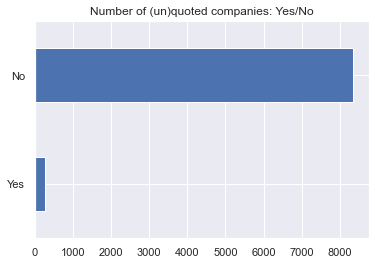

In [28]:
print(df_total['Quoted'].value_counts())
df_total['Quoted'].value_counts().sort_values().plot(kind = 'barh')
plt.title('Number of (un)quoted companies: Yes/No')
plt.show()

##### Country ISO code
- contains 'No Information'

In [29]:
# replace NaN in 'Country ISO code'
df_total['Country ISO code'].fillna("No Information", inplace = True) 

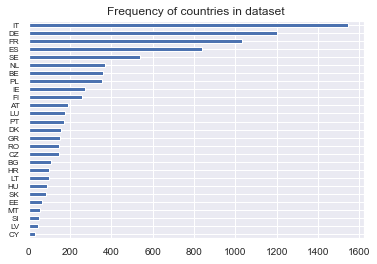

In [30]:
# print(df_total['Country ISO code'].value_counts())
df_total['Country ISO code'].value_counts().sort_values().plot(kind = 'barh')
plt.xticks(fontsize=10)
plt.yticks(fontsize=8)
plt.title('Frequency of countries in dataset')
plt.rcParams['figure.dpi'] = 250
plt.show()

##### NACE2

In [31]:
# df_total['NACE2'].value_counts().sort_values().to_list()

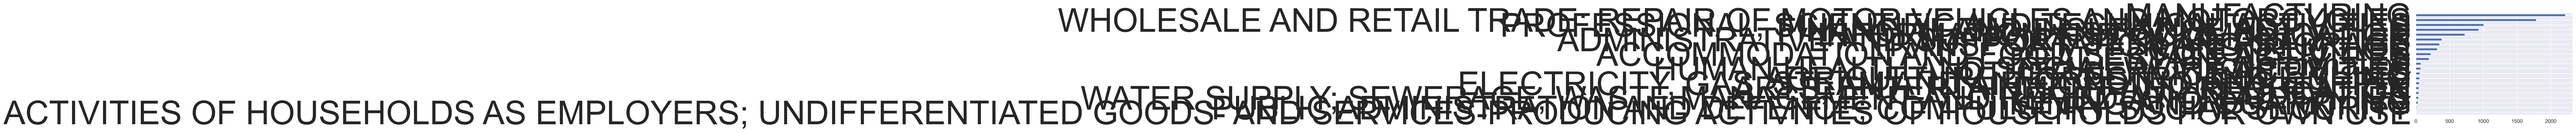

In [32]:
# print(df_total.loc[df_total['NACE2'].isnull() == True]['NACE2'])
# print(df_total.loc[df_total['NACE2'] == "n.a."]['NACE2'])
df_total['NACE2'].fillna("No Information", inplace = True) 
# print(df_total['NACE2'].value_counts())
df_total['NACE2'].value_counts().sort_values().plot(kind = 'barh')
plt.yticks(fontsize=70)
plt.rcParams['figure.dpi'] = 250
plt.show()

In [33]:
df_total

Company name Quoted Country ISO code  \
0                         KAUTH HOLDING GMBH & CO. KG     No               DE   
1                             APERAM STAINLESS EUROPE     No               FR   
2                             ZYLAB TECHNOLOGIES B.V.     No               NL   
3                              TECHNIP OIL & GAS B.V.     No               NL   
4                                   COATINC MOOK B.V.     No               NL   
...                                               ...    ...              ...   
10051                          VALRHONA ITALIA S.R.L.     No               IT   
10052                     FONDERIA METAL LEGHE S.R.L.     No               IT   
10053                                   ZANOLA S.R.L.     No               IT   
10054  BROWNHOUSE FRA LAN AIRPORT HOTEL GMBH & CO. KG     No               DE   
10055                                   HOME DECOR OU     No               EE   

                                                   NACE2  Years since today  \
0                     FINANCIAL AND INSURANCE ACTIVITIES                3.0   
1      WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VE...                2.0   
2                          INFORMATION AND COMMUNICATION                2.0   
3                                          MANUFACTURING                2.0   
4                                          MANUFACTURING                2.0   
...                                                  ...                ...   
10051  WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VE...                1.0   
10052                                      MANUFACTURING                1.0   
10053                                      MANUFACTURING                1.0   
10054          ACCOMMODATION AND FOOD SERVICE ACTIVITIES                2.0   
10055  WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VE...                1.0   

      Operating revenue EU (Turnover LAY) Number of employees (LAY)  \
0                            121062255.27                       515   
1                              2425755806                      n.a.   
2                                    n.a.                        54   
3                                    n.a.                         2   
4                                18991431                        48   
...                                   ...                       ...   
10051                            2726.484                        15   
10052                            3436.651                        15   
10053                            2677.177                        33   
10054                              2000.0                        40   
10055                            2350.705                         5   

               Size classification  DPO  Purpose  Acquired data  Data sharing  \
0      Large or Very large company    1        1              1             1   
1      Large or Very large company    1        1              0             0   
2      Large or Very large company    0        1              1             1   
3      Large or Very large company    1        1              1             1   
4      Large or Very large company    0        1              1             1   
...                            ...  ...      ...            ...           ...   
10051                          SME    1        1              1             1   
10052                          SME    1        1              1             1   
10053                          SME    0        1              1             1   
10054                          SME    1        1              1             1   
10055                          SME    1        1              1             1   

       Rights  
0           1  
1           1  
2           0  
3           1  
4           1  
...       ...  
10051       1  
10052       1  
10053       1  
10054       1  
10055       1  

[8614 rows x 13 columns]

##### Last avail. year (LAY)
- contains NaN

In [34]:
# print(df_total.loc[df_total['Years since today'].isnull() == True]['Years since today'])
# print(df_total.loc[df_total['Years since today'] == "n.a."]['Years since today'])
# df_total['Last avail. year (LAY)'].fillna("No Information", inplace = True) 
print(df_total['Years since today'].value_counts())
# df_total['Last avail. year (LAY)'].value_counts().sort_values().plot(kind = 'barh')

2.0    6129
1.0    1762
3.0     653
0.0      70
Name: Years since today, dtype: int64


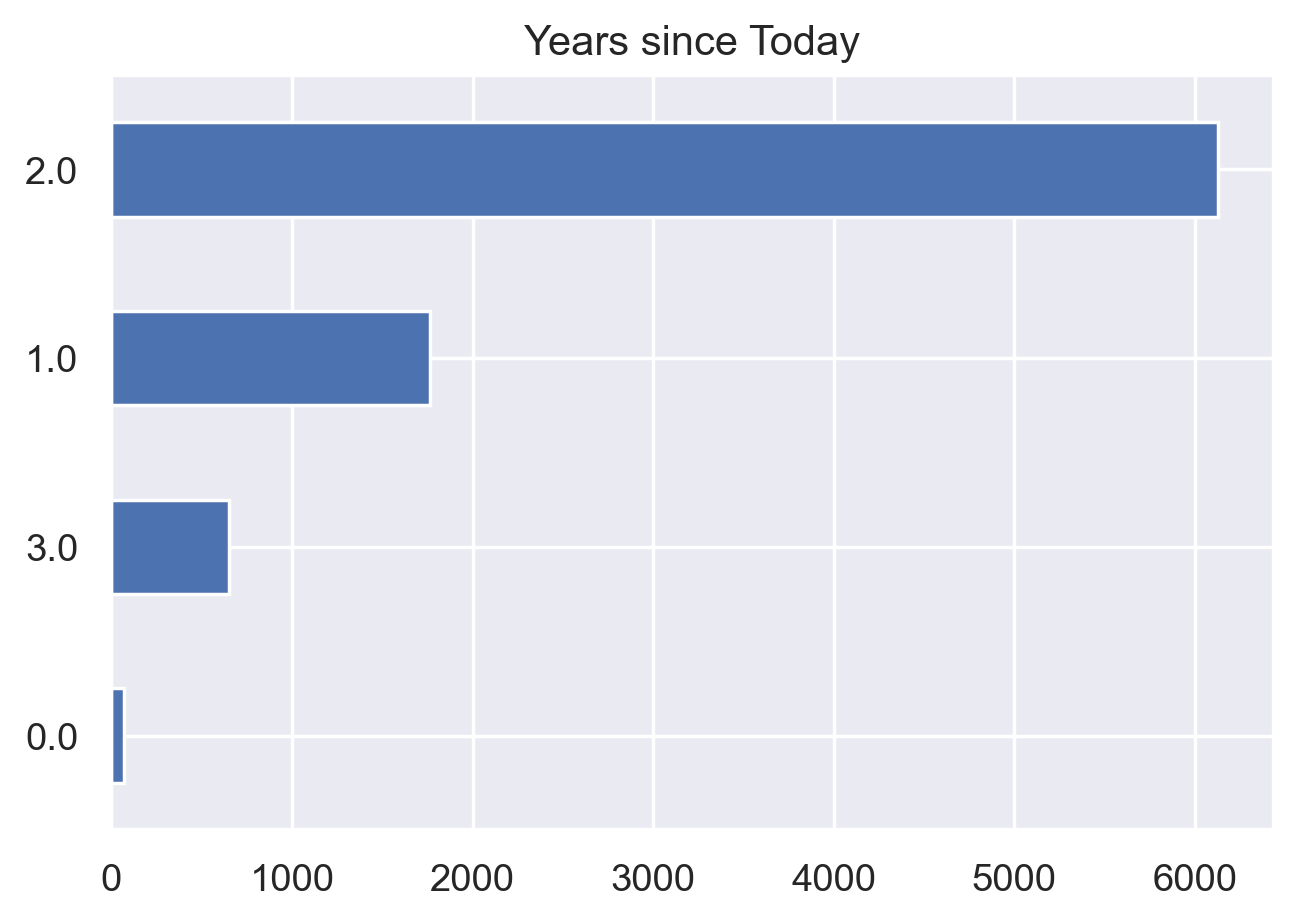

In [35]:
df_total['Years since today'].value_counts().sort_values().plot(kind = 'barh')
plt.title('Years since Today')
plt.show()

##### Number of employees (LAY) 
- 1536 n.a. -> np.nan
- 31 zero

In [36]:
# print(df_total.loc[df_total['Number of employees (LAY)'] == np.nan]['Number of employees (LAY)'])
# print(df_total.loc[df_total['Number of employees (LAY)'] == "n.a."]['Number of employees (LAY)'].size)
# print(df_total.loc[df_total['Number of employees (LAY)'] == '0']['Number of employees (LAY)'].size)

df_total['Number of employees (LAY)'] = df_total['Number of employees (LAY)'].replace('n.a.', np.nan)
# print(df_total['Last avail. year (LAY)'].value_counts())

# df_total['Number of employees (LAY)'] = df_total['Number of employees (LAY)'].replace('0', 0)
print(df_total['Number of employees (LAY)'].value_counts().head(10))
# df_total['Number of employees (LAY)'].value_counts().sort_values().plot(kind = 'barh')

3     302
7     160
8     160
4     159
2     159
15    144
12    141
13    140
9     140
6     140
Name: Number of employees (LAY), dtype: int64


##### Size classification

<AxesSubplot:>

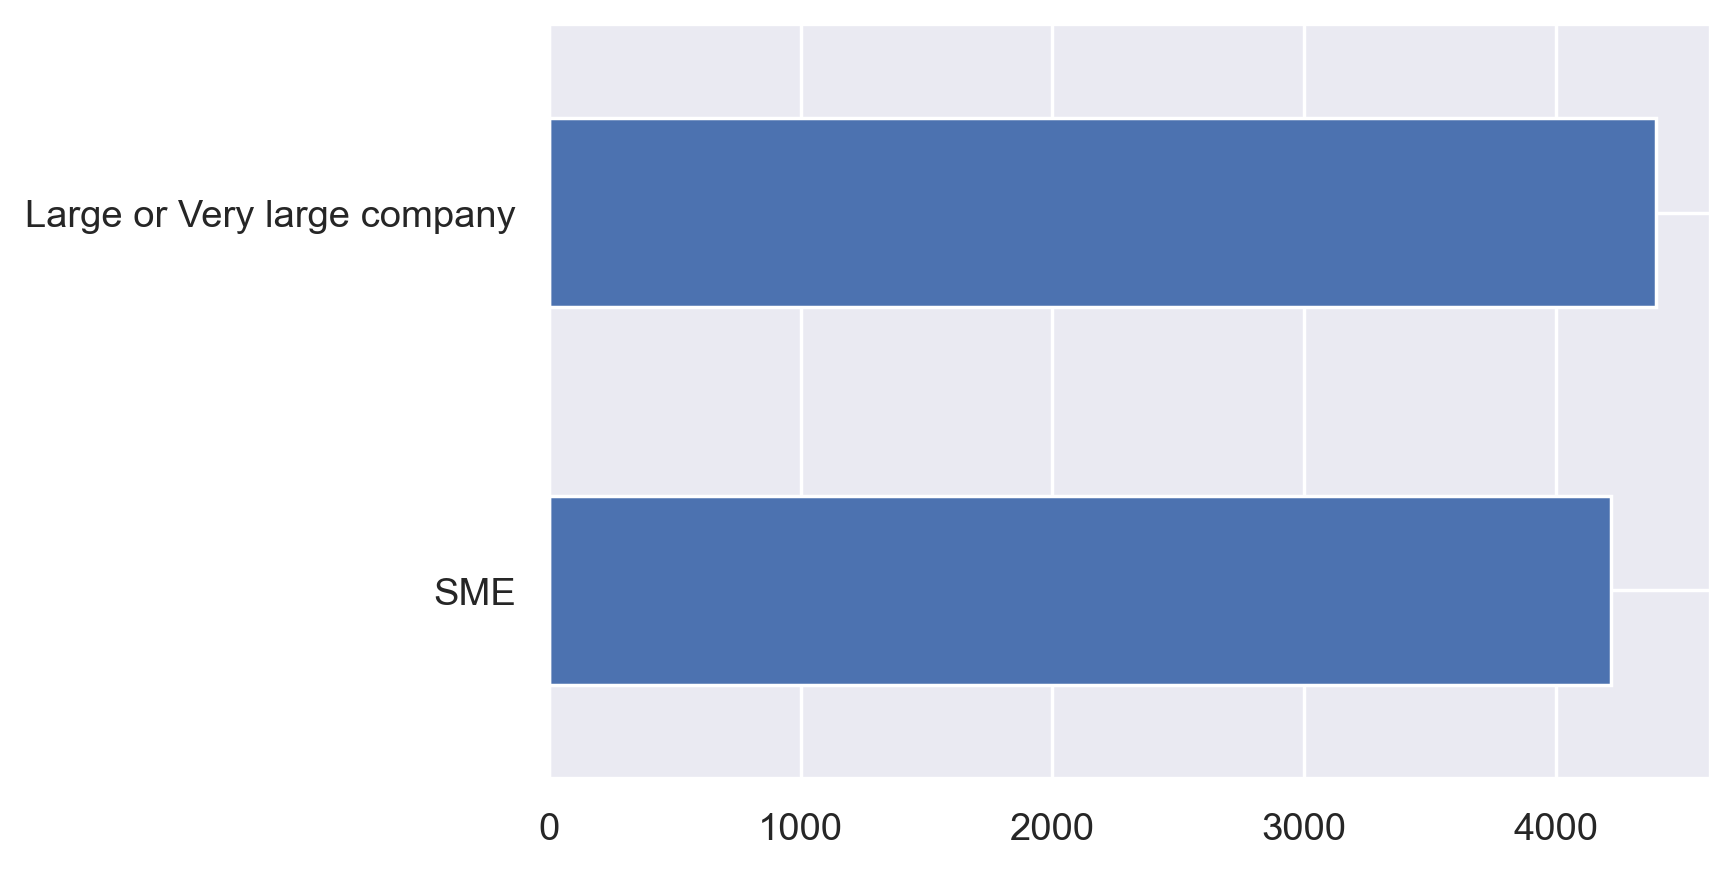

In [37]:
df_total['Size classification'].value_counts().sort_values().plot(kind = 'barh')

##### Operating revenue EU (Turnover LAY) - (Contains NaN)

In [38]:
df_total['Operating revenue EU (Turnover LAY)'] = df_total['Operating revenue EU (Turnover LAY)'].replace('n.a.', np.nan)
print(df_total.loc[df_total['Operating revenue EU (Turnover LAY)'].isnull() == True]['Operating revenue EU (Turnover LAY)'])
print(df_total.loc[df_total['Operating revenue EU (Turnover LAY)'] == "n.a."]['Operating revenue EU (Turnover LAY)'])

# df_total['Operating revenue EU (Turnover LAY)'] = df_total['Operating revenue EU (Turnover LAY)'].replace(np.nan, '-1')

2       NaN
3       NaN
5       NaN
10      NaN
16      NaN
       ... 
5005    NaN
5012    NaN
5026    NaN
5037    NaN
5059    NaN
Name: Operating revenue EU (Turnover LAY), Length: 770, dtype: object
Series([], Name: Operating revenue EU (Turnover LAY), dtype: object)


## Cast rows to proper object-type

In [39]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8614 entries, 0 to 10055
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Company name                         8614 non-null   object 
 1   Quoted                               8614 non-null   object 
 2   Country ISO code                     8614 non-null   object 
 3   NACE2                                8614 non-null   object 
 4   Years since today                    8614 non-null   float64
 5   Operating revenue EU (Turnover LAY)  7844 non-null   object 
 6   Number of employees (LAY)            7078 non-null   object 
 7   Size classification                  8614 non-null   object 
 8   DPO                                  8614 non-null   int64  
 9   Purpose                              8614 non-null   int64  
 10  Acquired data                        8614 non-null   int64  
 11  Data sharing                 

##### Cast selected columns to dtype = category

In [40]:
CATEGORICAL_DATA = ['Country ISO code', 'NACE2', 'Quoted', 'Size classification', 
                    'DPO', 'Purpose', 'Acquired data', 'Data sharing', 'Rights']

# BOOLEAN_DATA = ['Inactive', 'Quoted', 'Size classification', 'DPO', 'Purpose', 'Acquired data', 'Data sharing', 'Rights'] 

# INT_DATA = ['Number of employees (LAY)']

FLOAT_DATA = ['Years since today', 'Operating revenue EU (Turnover LAY)', 'Number of employees (LAY)']

In [41]:
# Define the lambda function: categorize_label
label_categorical = lambda x: x.astype('category')
# label_boolean = lambda x: x.astype(bool)
# bug in pandas: https://stackoverflow.com/questions/60024262/error-converting-object-string-to-int32-typeerror-object-cannot-be-converted
# label_int = lambda x: x.astype(float).astype('Int64')
label_float = lambda x: x.astype(float)


In [42]:
df_clean = df_total.copy()

In [43]:
# Convert df[LABELS] to a categorical type
df_clean[CATEGORICAL_DATA] = df_clean[CATEGORICAL_DATA].apply(label_categorical, axis=0)
# df_clean[BOOLEAN_DATA] = df_clean[BOOLEAN_DATA].apply(label_boolean, axis=0)
# df_clean[INT_DATA] = df_clean[INT_DATA].apply(label_int, axis=0)
df_clean[FLOAT_DATA] = df_clean[FLOAT_DATA].apply(label_float, axis=0)

# Print the converted dtypes
# print(le_classified[CATEGORICAL_DATA].dtypes)

#https://shravan-kuchkula.github.io/mutli-class-multi-label-pipeline/#encode-the-labels-as-categories

In [44]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8614 entries, 0 to 10055
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Company name                         8614 non-null   object  
 1   Quoted                               8614 non-null   category
 2   Country ISO code                     8614 non-null   category
 3   NACE2                                8614 non-null   category
 4   Years since today                    8614 non-null   float64 
 5   Operating revenue EU (Turnover LAY)  7844 non-null   float64 
 6   Number of employees (LAY)            7078 non-null   float64 
 7   Size classification                  8614 non-null   category
 8   DPO                                  8614 non-null   category
 9   Purpose                              8614 non-null   category
 10  Acquired data                        8614 non-null   category
 11  Data sharing    

In [45]:
df_clean.head(10)

Company name Quoted Country ISO code  \
0                        KAUTH HOLDING GMBH & CO. KG     No               DE   
1                            APERAM STAINLESS EUROPE     No               FR   
2                            ZYLAB TECHNOLOGIES B.V.     No               NL   
3                             TECHNIP OIL & GAS B.V.     No               NL   
4                                  COATINC MOOK B.V.     No               NL   
5                               MAIN CAPITAL IV B.V.     No               NL   
6                                             SYNOVA     No               FR   
7                             PCB CONNECT HOLDING AB     No               SE   
8                               RENATO MENEGATTI SRL     No               IT   
9  BROSE FAHRZEUGTEILE GMBH & CO. KOMMANDITGESELL...     No               DE   

                                               NACE2  Years since today  \
0                 FINANCIAL AND INSURANCE ACTIVITIES                3.0   
1  WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VE...                2.0   
2                      INFORMATION AND COMMUNICATION                2.0   
3                                      MANUFACTURING                2.0   
4                                      MANUFACTURING                2.0   
5                 FINANCIAL AND INSURANCE ACTIVITIES                2.0   
6  WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT AND R...                2.0   
7                 FINANCIAL AND INSURANCE ACTIVITIES                2.0   
8                                      MANUFACTURING                2.0   
9                                      MANUFACTURING                3.0   

   Operating revenue EU (Turnover LAY)  Number of employees (LAY)  \
0                         1.210623e+08                      515.0   
1                         2.425756e+09                        NaN   
2                                  NaN                       54.0   
3                                  NaN                        2.0   
4                         1.899143e+07                       48.0   
5                                  NaN                        NaN   
6                         2.025951e+07                        NaN   
7                         3.298043e+07                       82.0   
8                         3.064079e+07                      165.0   
9                         1.150593e+08                      116.0   

           Size classification DPO Purpose Acquired data Data sharing Rights  
0  Large or Very large company   1       1             1            1      1  
1  Large or Very large company   1       1             0            0      1  
2  Large or Very large company   0       1             1            1      0  
3  Large or Very large company   1       1             1            1      1  
4  Large or Very large company   0       1             1            1      1  
5  Large or Very large company   1       1             1            1      1  
6  Large or Very large company   0       1             1            1      0  
7  Large or Very large company   0       1             1            0      0  
8  Large or Very large company   0       1             0            1      0  
9  Large or Very large company   1       0             0            0      1

---

# Exploratory Data Analysis

#### CATEGORICAL DATA:
- 'Country ISO code'
- 'NACE2'
- 'Quoted'
- 'Size classification'
- 'DPO'
- 'Purpose'
- 'Acquired data'
- 'Data sharing'
- 'Rights'

#### NUMERICAL DATA:
- 'Operating revenue EU (Turnover LAY)'
- 'Number of employees (LAY)'

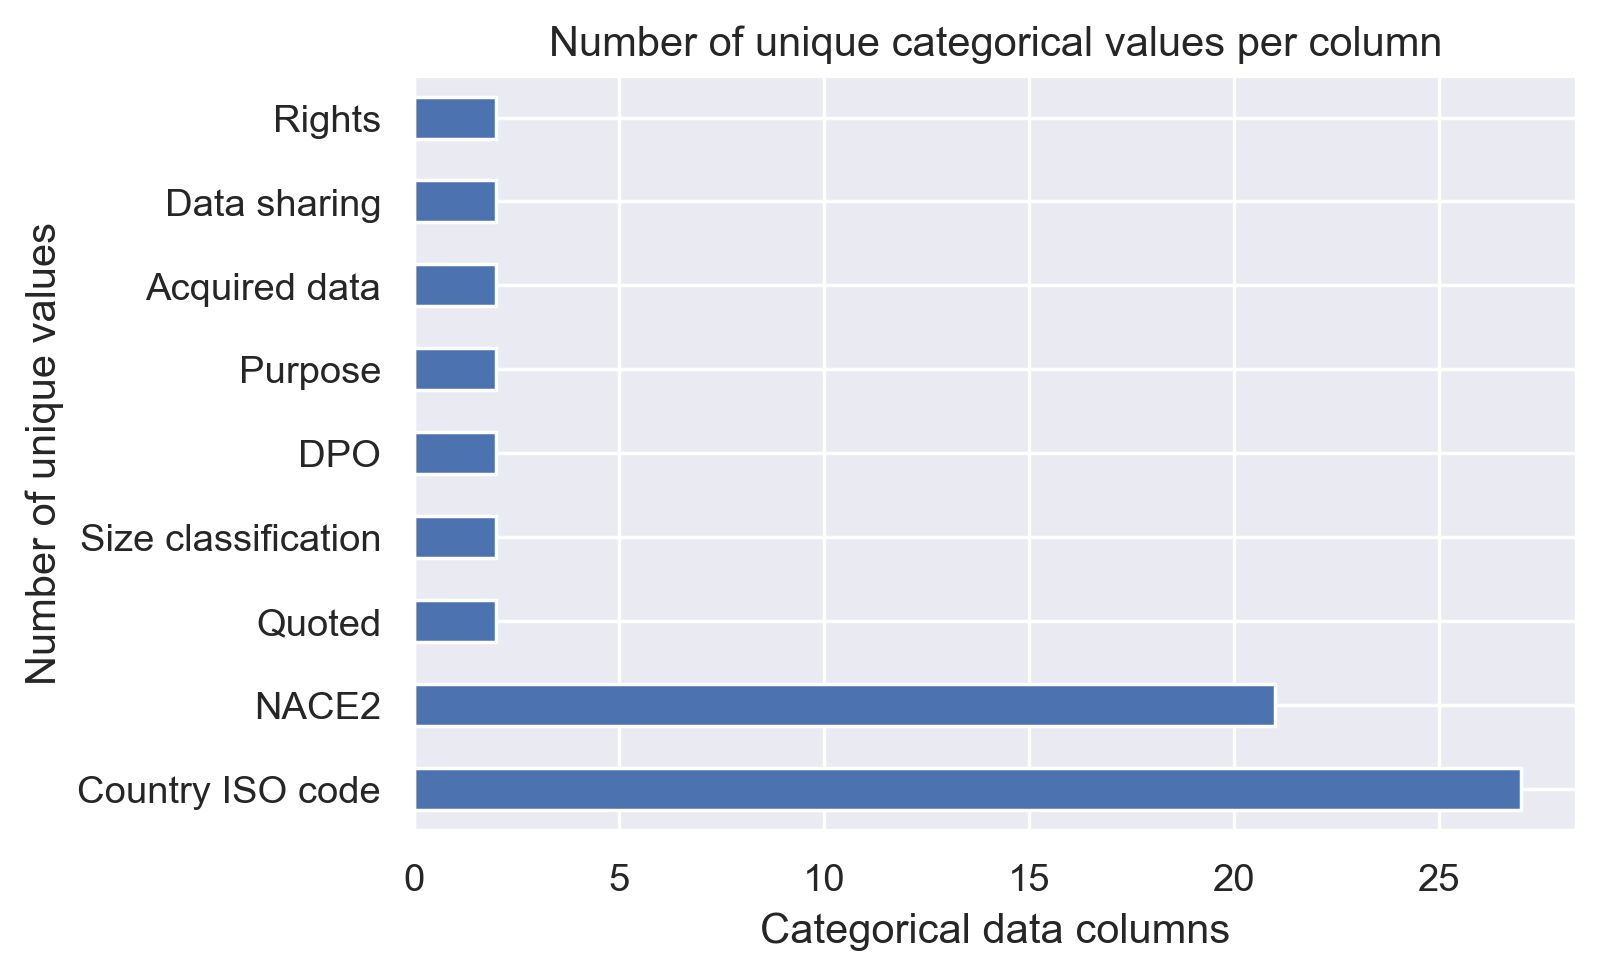

In [46]:
# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = df_clean[CATEGORICAL_DATA].apply(pd.Series.nunique, axis='rows')

# Plot number of unique values for each label
num_unique_labels.plot(kind='barh')

# Label the axes
plt.xlabel('Categorical data columns')
plt.ylabel('Number of unique values')
plt.title('Number of unique categorical values per column')
# Display the plot
plt.show()

###### Create new DFs for LEs and SMEs to explore their individual operating revenue

In [47]:
df_LE = df_clean[df_clean['Size classification'] == "Large or Very large company"]
df_SME = df_clean[df_clean['Size classification'] == "SME"]

In [48]:
df_clean.describe().apply(lambda s: s.apply('{0:.5f}'.format))

Years since today Operating revenue EU (Turnover LAY)  \
count        8614.00000                          7844.00000   
mean            1.85500                     105429602.32213   
std             0.54025                    1116528806.54177   
min             0.00000                     -15489018.15000   
25%             2.00000                          6549.20893   
50%             2.00000                       4417532.97861   
75%             2.00000                      24158028.44786   
max             3.00000                   44937000000.00000   

      Number of employees (LAY)  
count                7078.00000  
mean                  296.32594  
std                  2696.71557  
min                     0.00000  
25%                    12.00000  
50%                    32.00000  
75%                   107.00000  
max                168000.00000

##### Describe LEs

In [49]:
df_LE.describe().apply(lambda s: s.apply('{0:.5f}'.format))

Years since today Operating revenue EU (Turnover LAY)  \
count        4397.00000                          3627.00000   
mean            1.95997                     225816054.63552   
std             0.49817                    1633857131.96549   
min             0.00000                     -15489018.15000   
25%             2.00000                      12998050.50000   
50%             2.00000                      27837985.00000   
75%             2.00000                      82679458.65000   
max             3.00000                   44937000000.00000   

      Number of employees (LAY)  
count                3448.00000  
mean                  584.40284  
std                  3842.94469  
min                     0.00000  
25%                    38.00000  
50%                   107.50000  
75%                   276.25000  
max                168000.00000

##### Describe SMEs

In [50]:
df_SME.describe().apply(lambda s: s.apply('{0:.5f}'.format))

Years since today Operating revenue EU (Turnover LAY)  \
count        4217.00000                          4217.00000   
mean            1.74555                       1886405.13439   
std             0.56039                       2486819.90416   
min             0.00000                          1075.56806   
25%             1.00000                          2939.76400   
50%             2.00000                          9764.46757   
75%             2.00000                       3100000.00000   
max             3.00000                      11022509.00000   

      Number of employees (LAY)  
count                3630.00000  
mean                   22.69256  
std                    22.76459  
min                     0.00000  
25%                     7.00000  
50%                    15.00000  
75%                    30.00000  
max                   249.00000

#### Boxplot: Size classification vs. Operating revenue

0.25    6.549209e+03
0.50    4.417533e+06
0.75    2.415803e+07
Name: Operating revenue EU (Turnover LAY), dtype: float64
AxesSubplot(0.1,0.15;0.8x0.75)


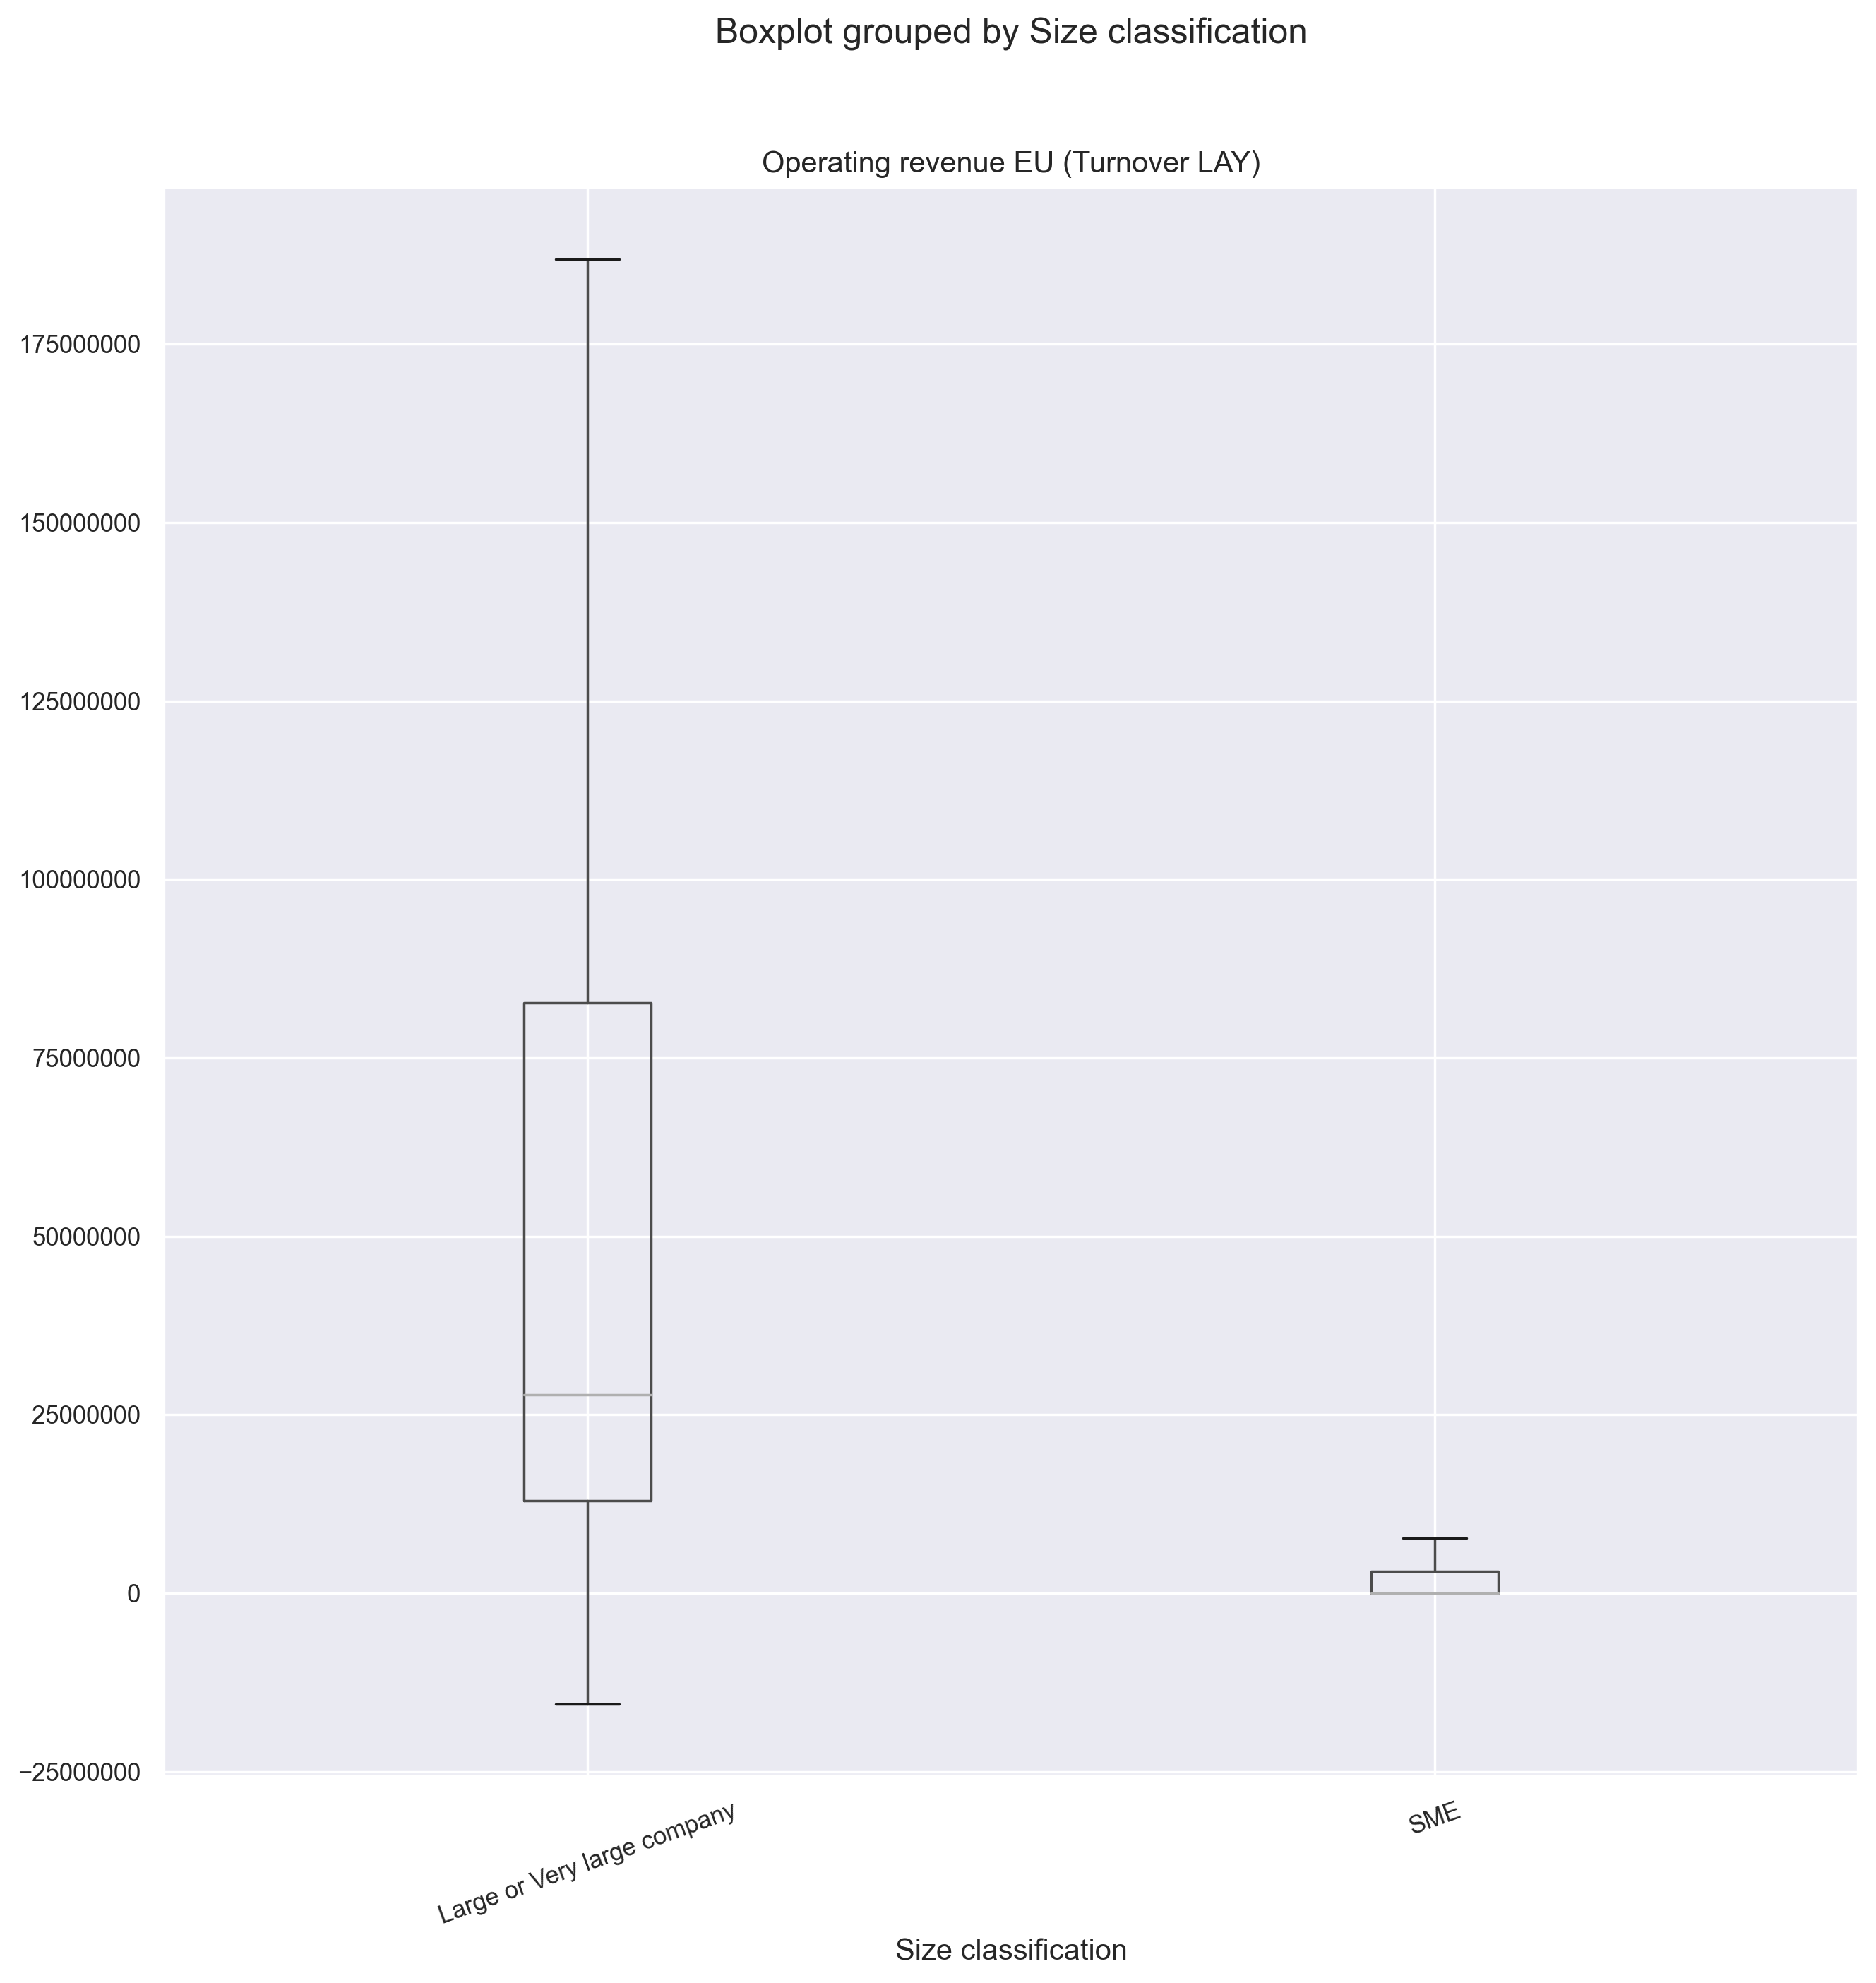

In [51]:
print(df_clean['Operating revenue EU (Turnover LAY)'].quantile([0.25,0.5,0.75]))

fig, ax = plt.subplots(figsize=(12,12))
boxplot=df_clean.boxplot(column=['Operating revenue EU (Turnover LAY)'],
                         by='Size classification',grid=True, 
                         rot=20, fontsize=10,
                         ax=ax,
                         showfliers=False)
boxplot.yaxis.get_major_formatter().set_scientific(False)
print(boxplot)

##### Boxplot LEs: Size classification vs. Operating revenue

AxesSubplot(0.125,0.125;0.775x0.755)


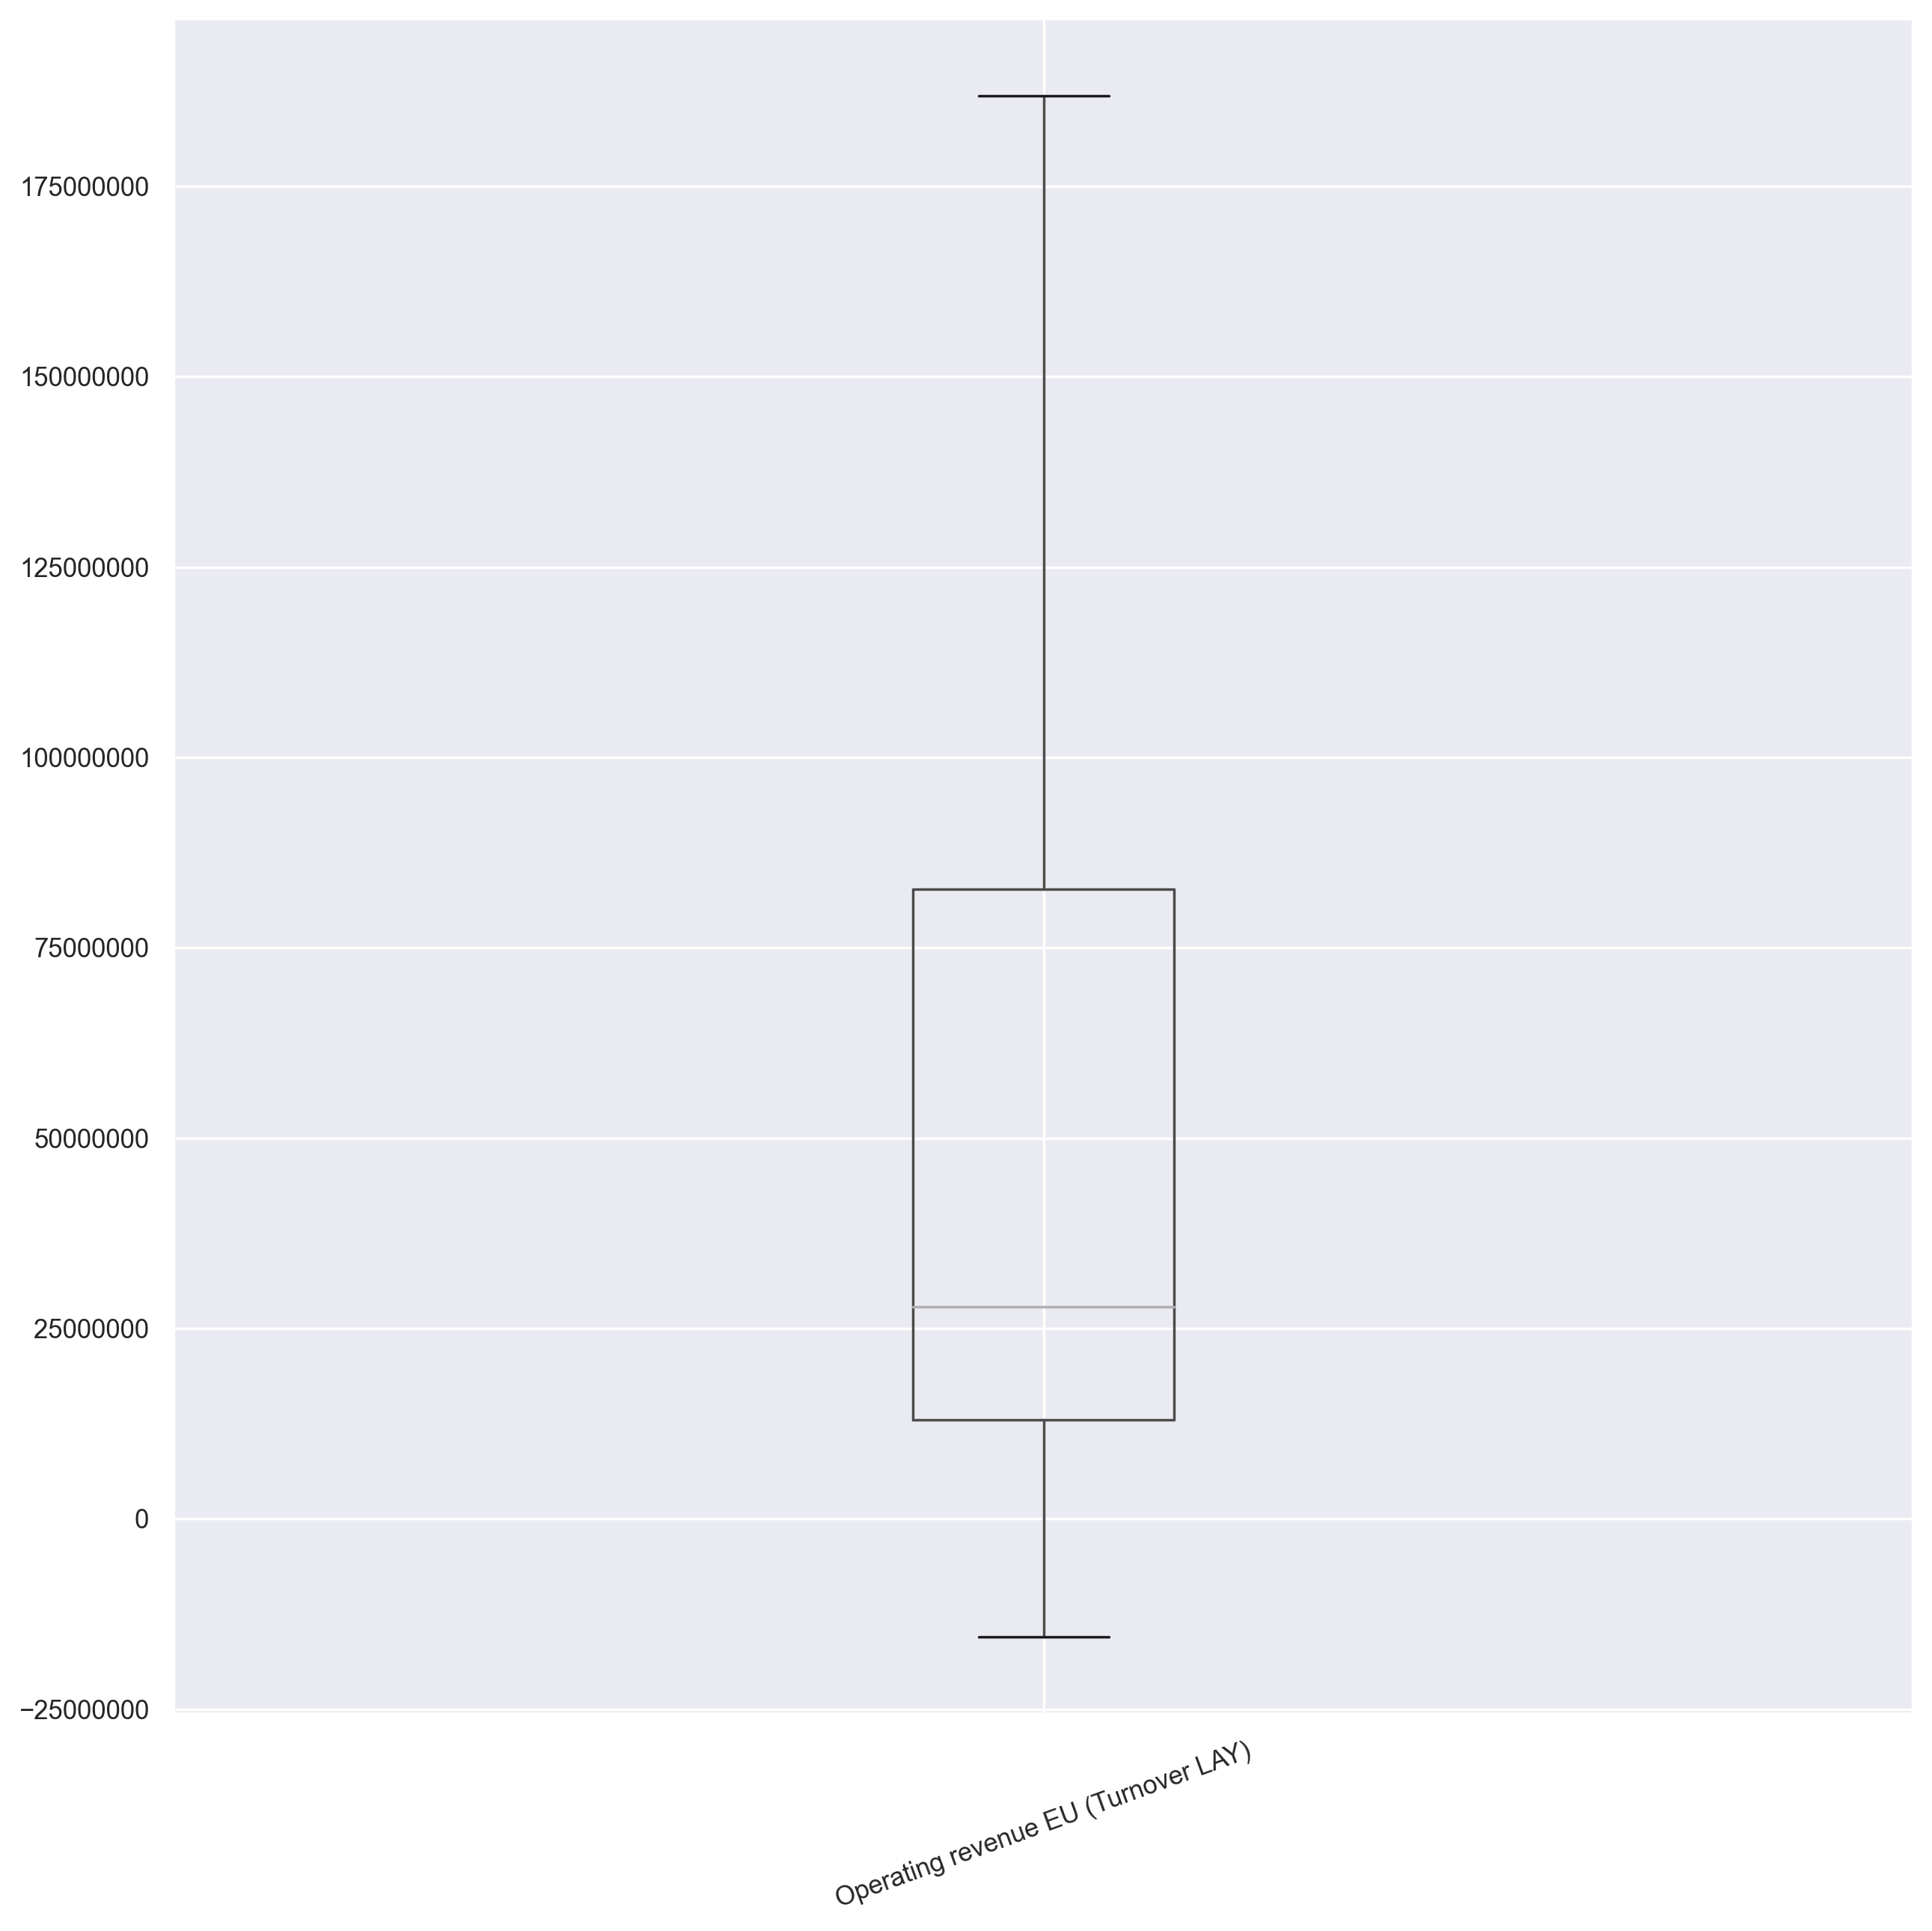

In [52]:
fig, ax = plt.subplots(figsize=(12,12))
boxplot=df_LE.boxplot(column=['Operating revenue EU (Turnover LAY)'],
                         grid=True, 
                         rot=20, fontsize=10,
                         ax=ax,
                         showfliers=False)
boxplot.yaxis.get_major_formatter().set_scientific(False)
print(boxplot)

##### Boxplot SME: Size classification vs. Operating revenue

AxesSubplot(0.125,0.125;0.775x0.755)


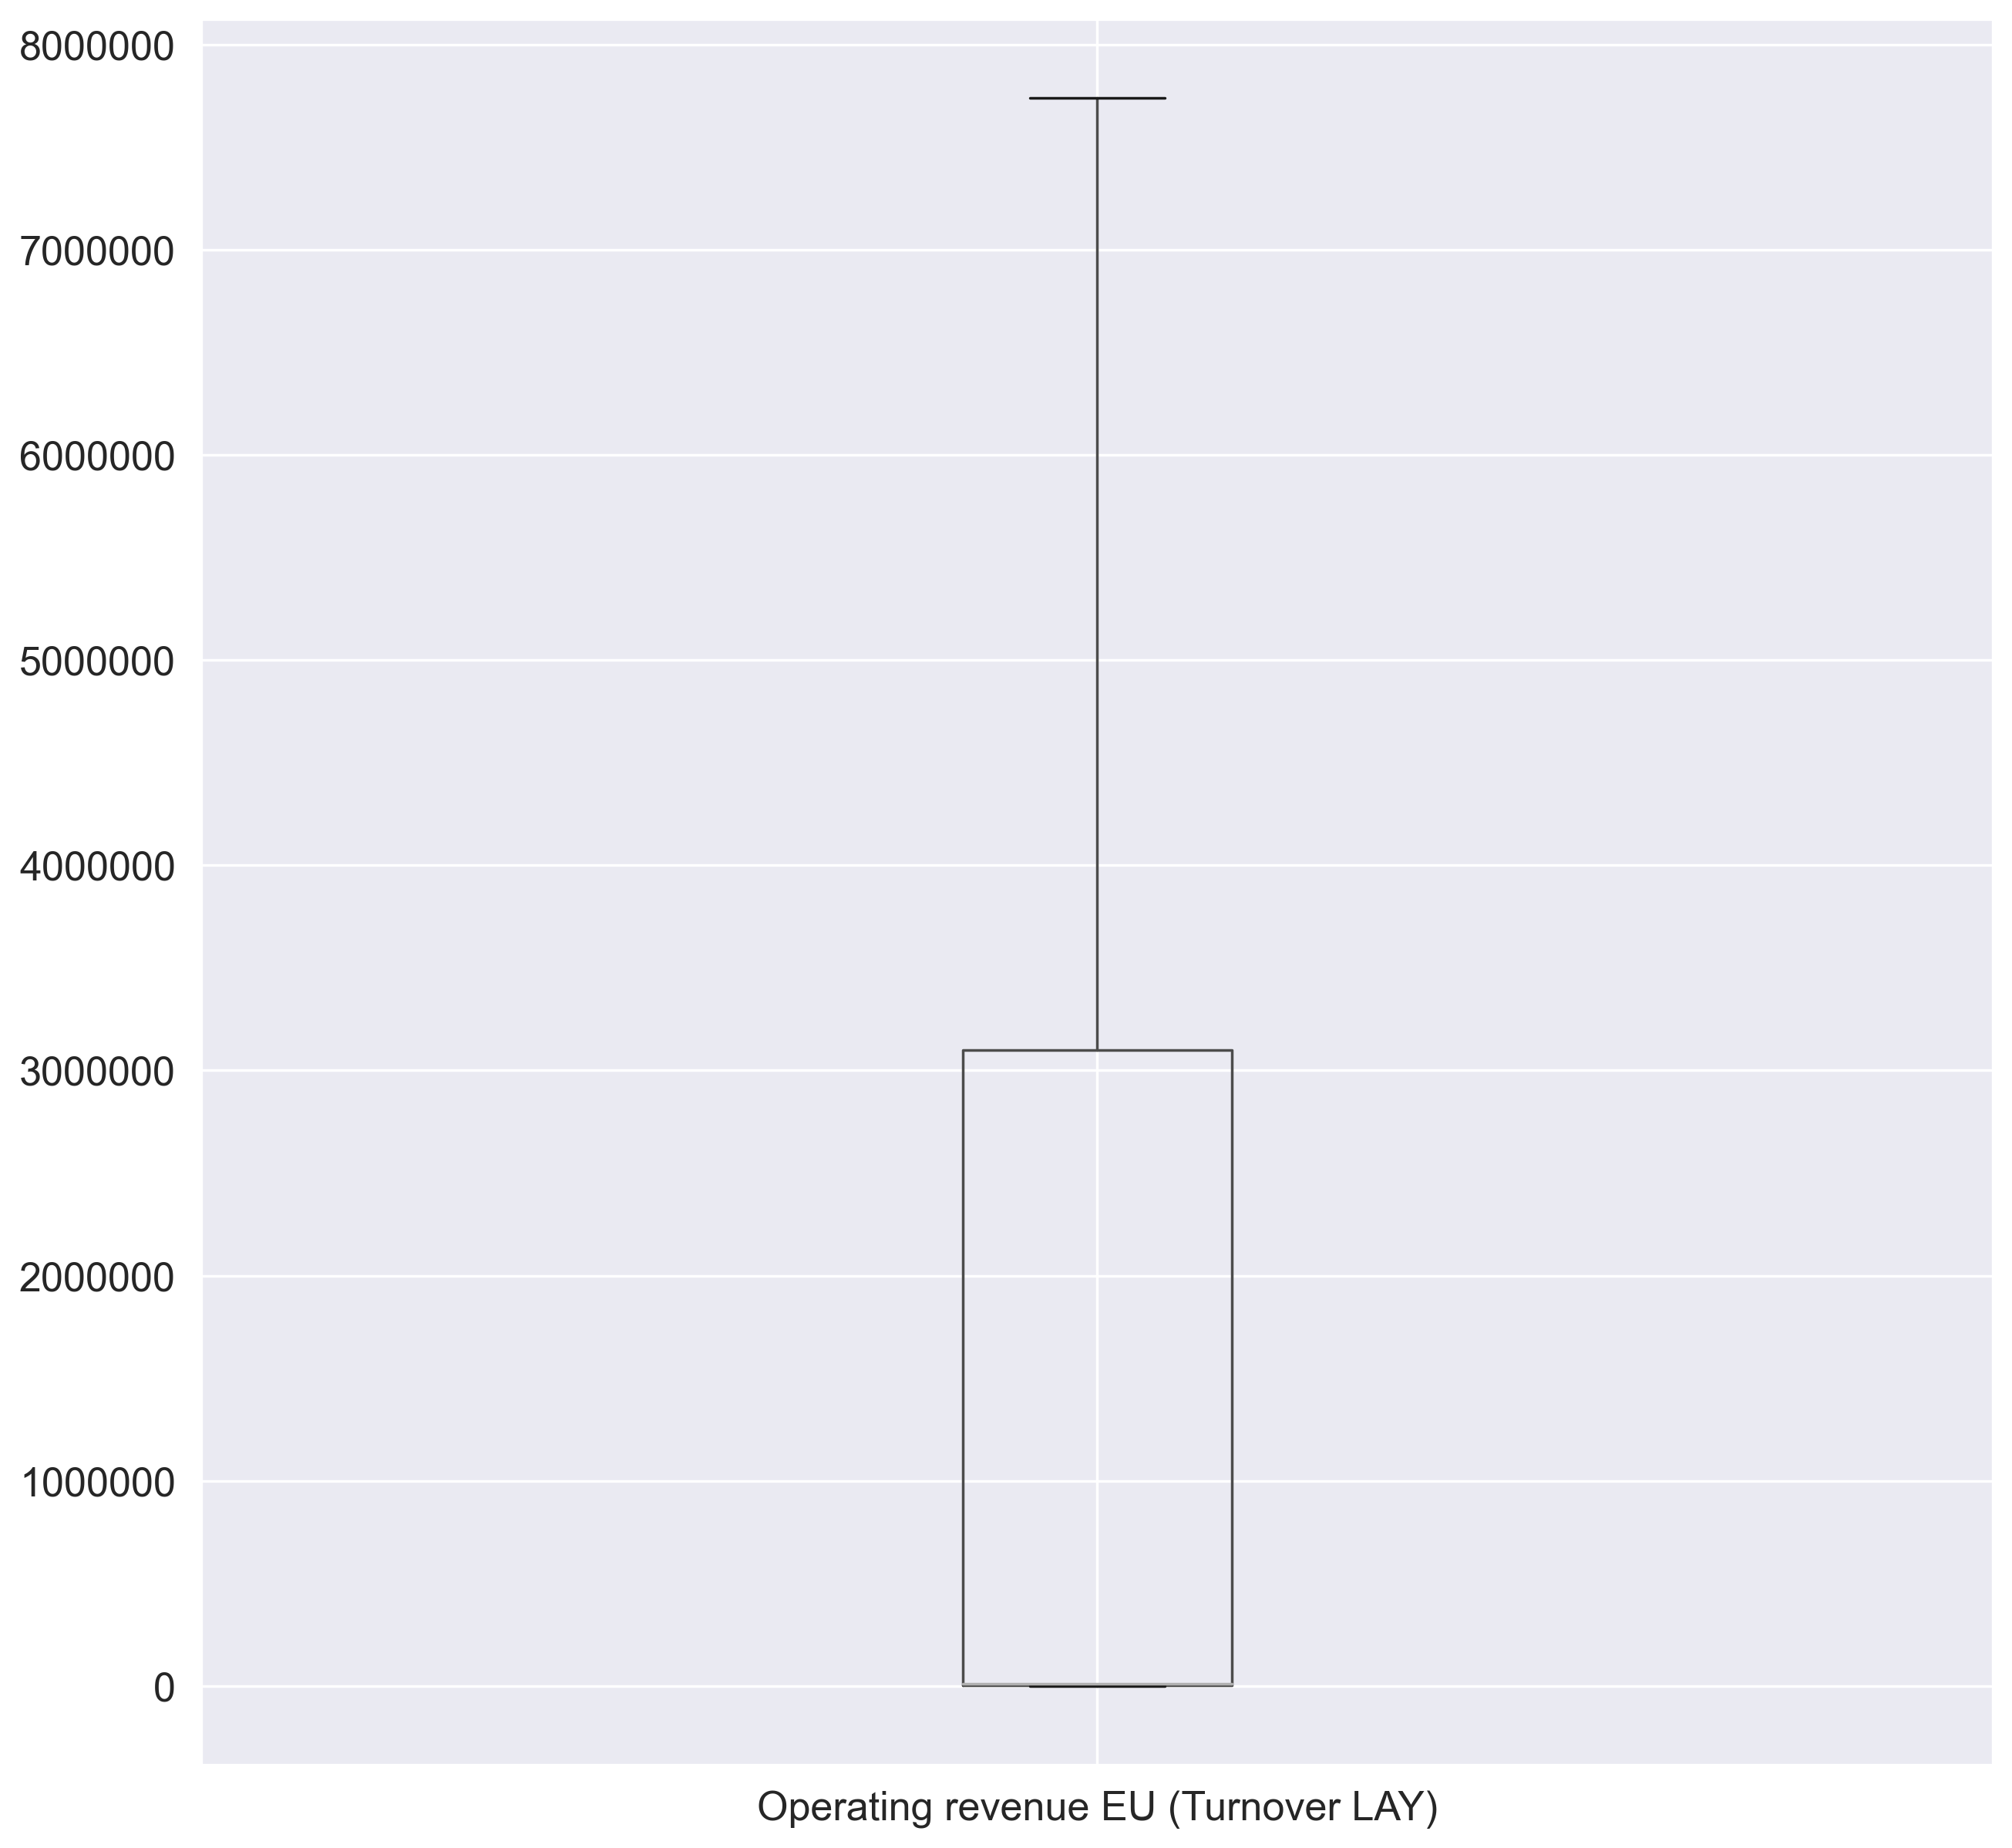

In [53]:
fig, ax = plt.subplots(figsize=(12,12))
boxplot=df_SME.boxplot(column=['Operating revenue EU (Turnover LAY)'],
                         grid=True, 
                         fontsize=15,
                         ax=ax,
                         showfliers=False)
boxplot.yaxis.get_major_formatter().set_scientific(False)
print(boxplot)

###### SME

In [54]:
print("Min: ", df_clean[df_clean['Size classification'] == 'SME']['Operating revenue EU (Turnover LAY)'].min())
print("Max: ", df_clean[df_clean['Size classification'] == 'SME']['Operating revenue EU (Turnover LAY)'].max())

Min:  1075.56805730974
Max:  11022509.0


###### LE

In [55]:
print("Min: ", df_clean[df_clean['Size classification'] == 'Large or Very large company']['Operating revenue EU (Turnover LAY)'].min())
print("Max: ", df_clean[df_clean['Size classification'] == 'Large or Very large company']['Operating revenue EU (Turnover LAY)'].max())

Min:  -15489018.15
Max:  44937000000.0


---
---

# Analysis

### Logistic Regression (LR)
We aim to use LR to identify correlation between variables in the dataset.

Sources:
- https://www.datainsightonline.com/post/beginner-s-guide-to-logistic-regression-in-python
- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [56]:
# company name is not relevant for the analysis
df_clean = df_clean.drop('Company name', axis=1)

#remove years since today
df_clean = df_clean.drop('Years since today', axis=1)

In [57]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8614 entries, 0 to 10055
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Quoted                               8614 non-null   category
 1   Country ISO code                     8614 non-null   category
 2   NACE2                                8614 non-null   category
 3   Operating revenue EU (Turnover LAY)  7844 non-null   float64 
 4   Number of employees (LAY)            7078 non-null   float64 
 5   Size classification                  8614 non-null   category
 6   DPO                                  8614 non-null   category
 7   Purpose                              8614 non-null   category
 8   Acquired data                        8614 non-null   category
 9   Data sharing                         8614 non-null   category
 10  Rights                               8614 non-null   category
dtypes: category(9), 

In [58]:
# excluded company name in CSV file for privacy reasons
df_clean.to_csv("8614.csv", index=True, index_label = 'Company index')

# LR with Statsmodels
Interesting materials:
- https://pypi.org/project/statsmodels/
- https://www.statsmodels.org/devel/index.html
- https://www.statsmodels.org/dev/gettingstarted.html
- https://datatofish.com/statsmodels-linear-regression/
- https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/
- https://www.statsmodels.org/stable/examples/notebooks/generated/regression_diagnostics.html
- https://statsmaths.github.io/stat289-f18/solutions/tutorial15-statsmodels.html
- https://stats.stackexchange.com/questions/252996/logit-in-statsmodels-give-negative-coefficents

In [59]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None)

In [60]:
# create a copy of the dataframe
df_sm = df_clean.copy()

In [61]:
# explore dataframe
df_sm.dtypes

Quoted                                 category
Country ISO code                       category
NACE2                                  category
Operating revenue EU (Turnover LAY)     float64
Number of employees (LAY)               float64
Size classification                    category
DPO                                    category
Purpose                                category
Acquired data                          category
Data sharing                           category
Rights                                 category
dtype: object

##### Identify potential correlations

In [62]:
df_sm.corr()

Operating revenue EU (Turnover LAY)  \
Operating revenue EU (Turnover LAY)                             1.000000   
Number of employees (LAY)                                       0.661943   

                                     Number of employees (LAY)  
Operating revenue EU (Turnover LAY)                   0.661943  
Number of employees (LAY)                             1.000000

No correlations between the numerical variables, we will do this again after encoding the categorical data.

##### Identify missing data

In [63]:
df_sm.isna().sum()

Quoted                                    0
Country ISO code                          0
NACE2                                     0
Operating revenue EU (Turnover LAY)     770
Number of employees (LAY)              1536
Size classification                       0
DPO                                       0
Purpose                                   0
Acquired data                             0
Data sharing                              0
Rights                                    0
dtype: int64

We need to preprocess "Operating revenue EU (Turnover LAY)" and "Number of employees (LAY)" to handle the NaNs. We will choose median for both as there are outliers in both datasets that affect the mean. 

In [64]:
df_sm['Number of employees (LAY)'].fillna((df_sm['Number of employees (LAY)'].median()), inplace=True)
df_sm['Operating revenue EU (Turnover LAY)'].fillna((df_sm['Operating revenue EU (Turnover LAY)'].median()), inplace=True)

In [65]:
df_sm['Size classification'].values

['Large or Very large company', 'Large or Very large company', 'Large or Very large company', 'Large or Very large company', 'Large or Very large company', ..., 'SME', 'SME', 'SME', 'SME', 'SME']
Length: 8614
Categories (2, object): ['Large or Very large company', 'SME']

In [66]:
df_sm['Size classification'].replace("SME", 0, inplace=True)
df_sm['Size classification'].replace("Large or Very large company", 1, inplace=True)

A better solution, however, would be choosing the mean based on the size classification. 

In [67]:
df_sm['Quoted'].replace("Yes", 1, inplace=True)
df_sm['Quoted'].replace("No", 0, inplace=True)

## Explore correlations

In [68]:
GDPR_labels = ['DPO', "Purpose", "Acquired data", "Data sharing", "Rights"]

In [69]:
train, test = train_test_split(df_sm, test_size=0.2, random_state=42)
X_train = train.drop(GDPR_labels,axis=1) # independant features

In [70]:
# Encode non-numerical categorical data, and drop first to avoid collinearity
X_train = pd.get_dummies(X_train, drop_first = True)

___LinAlgError: Singular matrix___

Maybe due to collinearity, or multicollinearity. 
- __Correlation:__ linear relationship between 2 variables
    - df.corr(), 2 variables involved
- __Collinearity:__ 2 or more independent variables (a.k.a. predictors) have a strong linear relationship
    - df.corr(), 2 or more ind. var.
- __Multicollinearity:__ special case of collinearity where a strong linear relationship exists between 3 or more independent variables even if no pair of variables has a high correlation
    - variance inflation factor (VIF)
    - As a rule of thumb, a VIF > 10 is a sign of multicollinearity [source: Regression Methods in Biostatistics, Vittinghoff et al.]. However, this is somewhat an oversimplification. 


Documentatie adviseert echter drempelwaarde van 5:
_One recommendation is that if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this._

Sources:
- https://quantifyinghealth.com/correlation-collinearity-multicollinearity/
- https://towardsdatascience.com/everything-you-need-to-know-about-multicollinearity-2f21f082d6dc
- https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html

C:\Users\aaberkan\Anaconda3\lib\site-packages\seaborn\matrix.py:1204: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


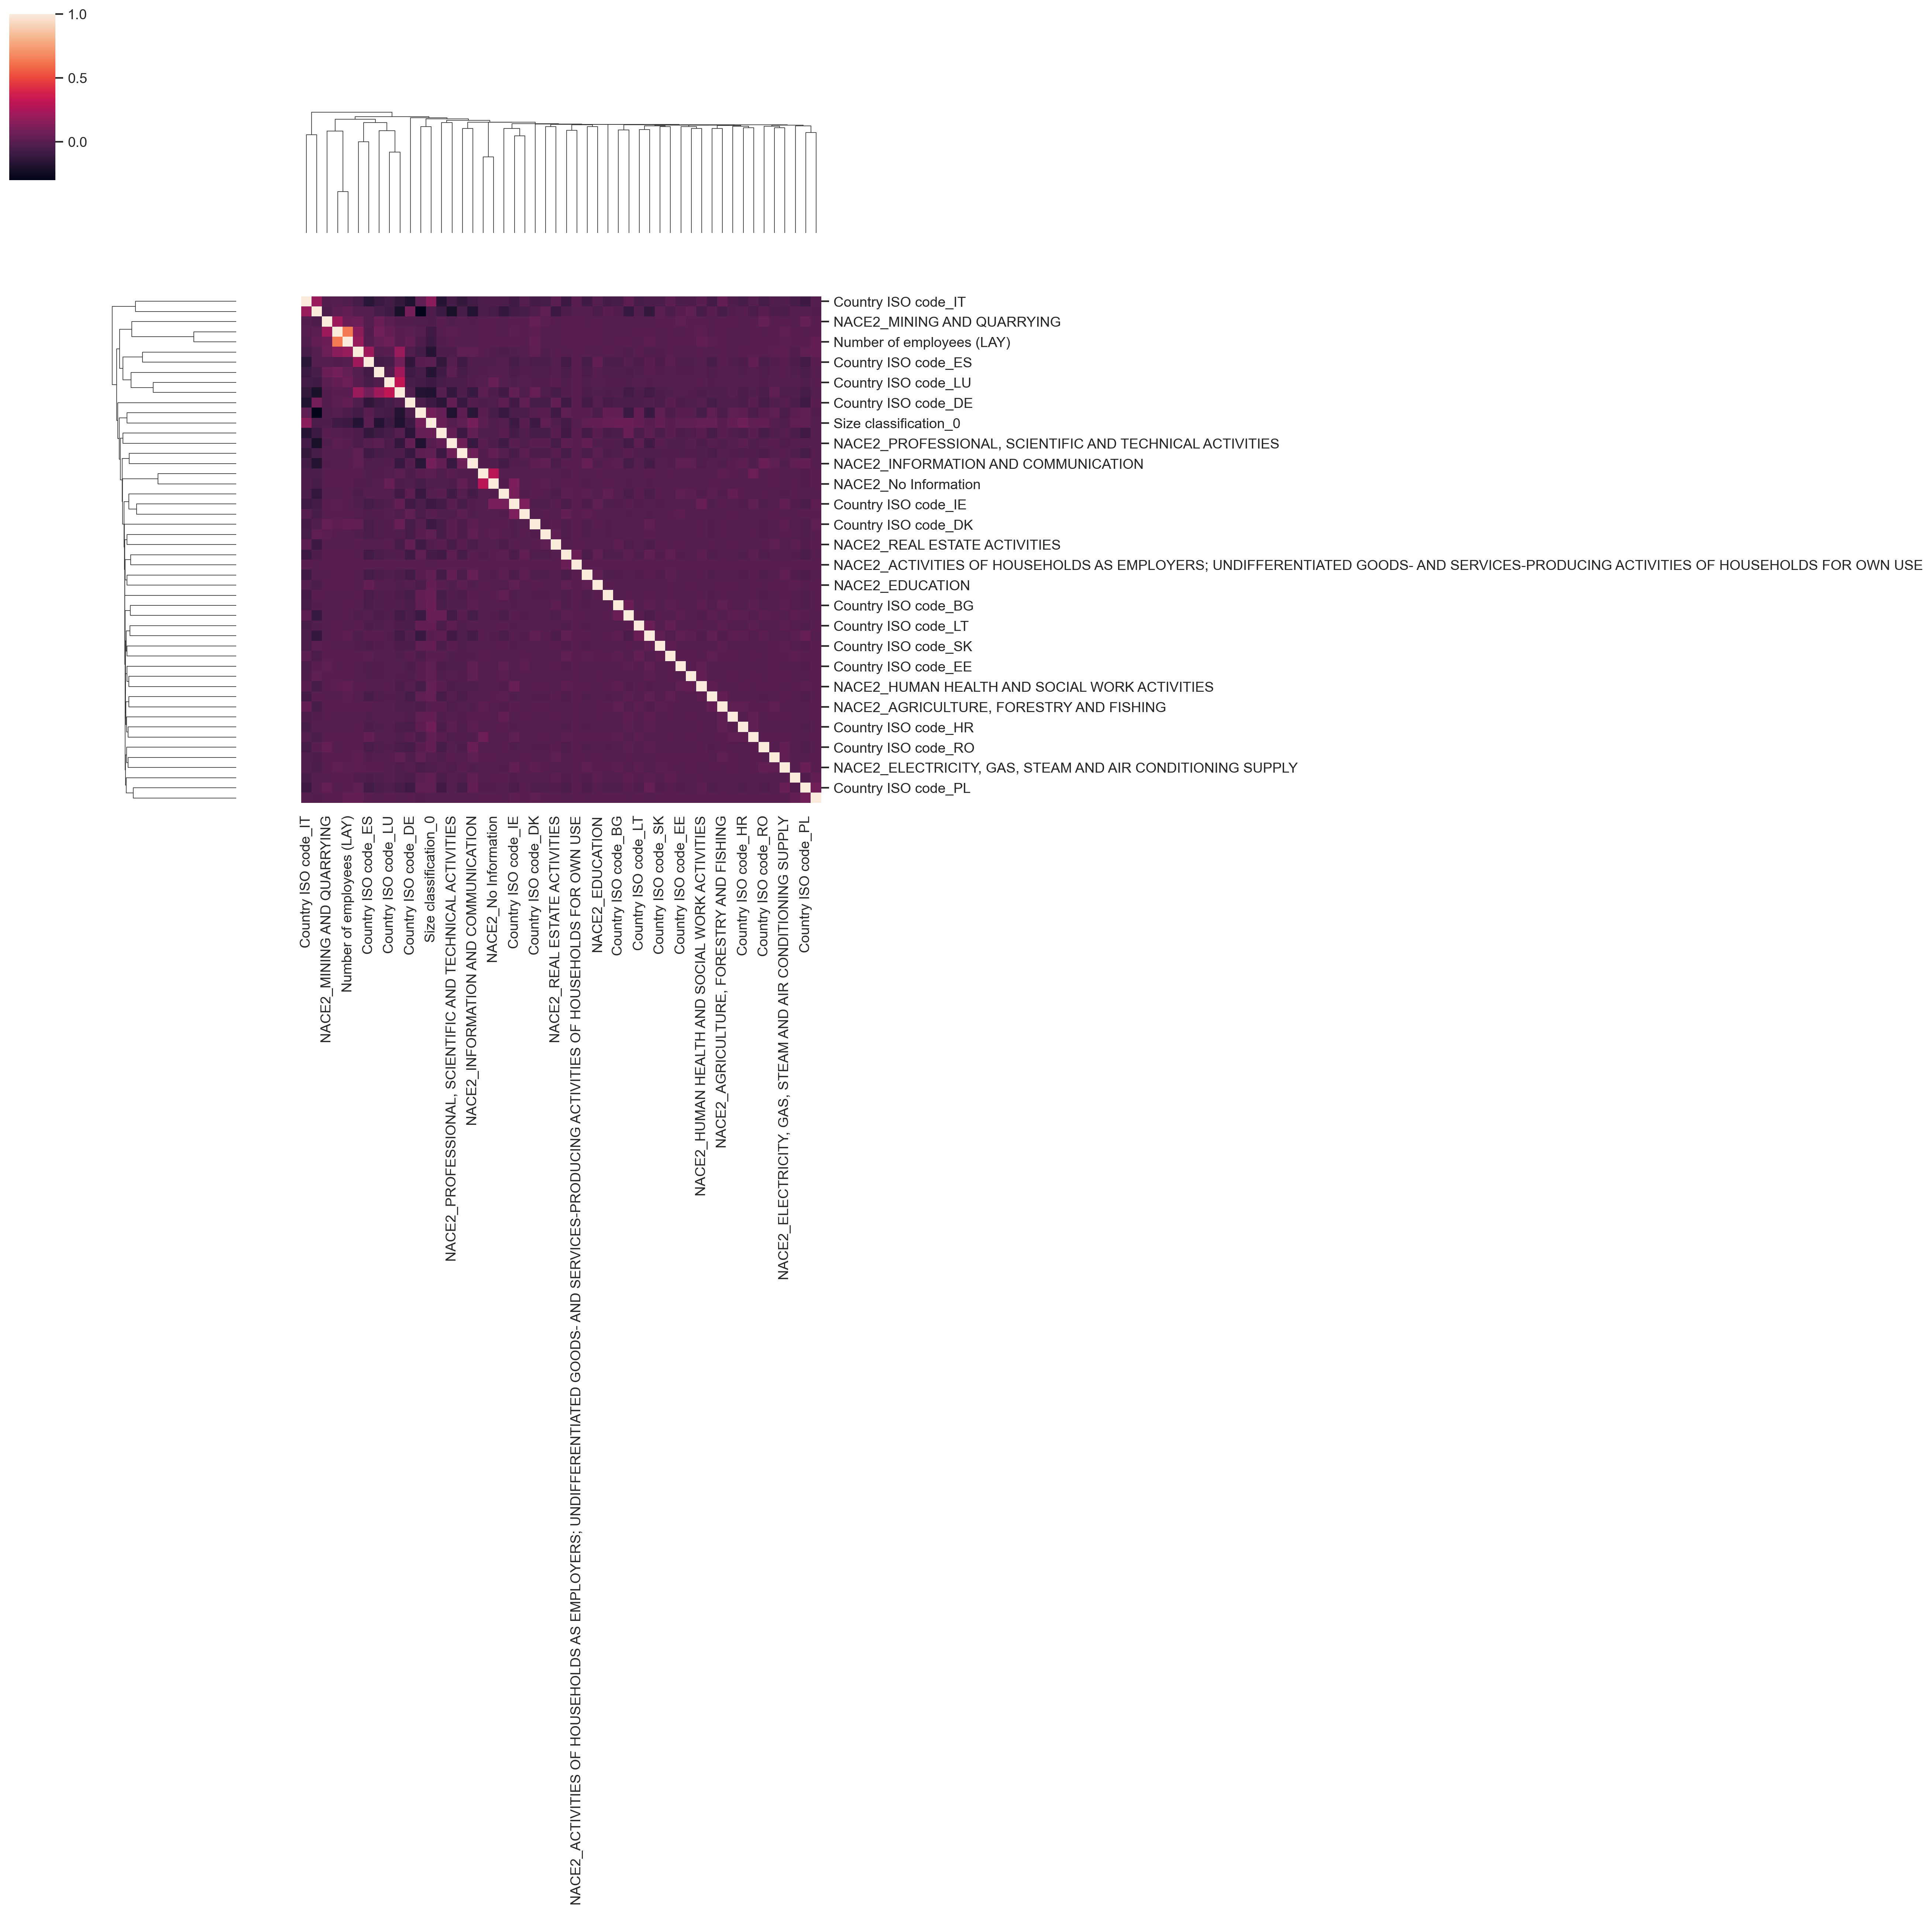

In [71]:
X = df_sm.drop(GDPR_labels,axis=1) # independant features
X = pd.get_dummies(X, drop_first = True)
# X = X.loc[:, X.columns != 'NACE2_ACTIVITIES OF HOUSEHOLDS AS EMPLOYERS; UNDIFFERENTIATED GOODS- AND SERVICES-PRODUCING ACTIVITIES OF HOUSEHOLDS FOR OWN USE']
# X = sm.add_constant(X)
    
sns.clustermap(X.corr())

In [73]:
for cname in list(X.columns.values):
    print(cname)
    print(X[cname].value_counts())
    print()
    print()
    print("*******************************")

Operating revenue EU (Turnover LAY)
4.417533e+06    848
3.136697e+03     81
0.000000e+00     29
6.000000e+06     12
1.500000e+06     11
               ... 
4.675948e+03      1
2.940249e+03      1
4.725835e+06      1
1.987890e+08      1
3.571908e+07      1
Name: Operating revenue EU (Turnover LAY), Length: 7460, dtype: int64


*******************************
Number of employees (LAY)
32.0       1575
3.0         302
7.0         160
8.0         160
2.0         159
           ... 
1931.0        1
610.0         1
514.0         1
867.0         1
19052.0       1
Name: Number of employees (LAY), Length: 886, dtype: int64


*******************************
Quoted_1
0    8353
1     261
Name: Quoted_1, dtype: int64


*******************************
Country ISO code_BE
0    8257
1     357
Name: Country ISO code_BE, dtype: int64


*******************************
Country ISO code_BG
0    8506
1     108
Name: Country ISO code_BG, dtype: int64


*******************************
Country ISO code_CY
0    

In [74]:
X.corr()
# X.corr().to_clipboard()

Operating revenue EU (Turnover LAY)  \
Operating revenue EU (Turnover LAY)                                                                                                                          1.000000   
Number of employees (LAY)                                                                                                                                    0.636341   
Quoted_1                                                                                                                                                     0.150606   
Country ISO code_BE                                                                                                                                         -0.002233   
Country ISO code_BG                                                                                                                                         -0.008538   
Country ISO code_CY                                                                                                                                         -0.004445   
Country ISO code_CZ                                                                                                                                         -0.007973   
Country ISO code_DE                                                                                                                                          0.006638   
Country ISO code_DK                                                                                                                                          0.010046   
Country ISO code_EE                                                                                                                                         -0.006301   
Country ISO code_ES                                                                                                                                         -0.017764   
Country ISO code_FI                                                                                                                                          0.000651   
Country ISO code_FR                                                                                                                                         -0.010844   
Country ISO code_GR                                                                                                                                         -0.008262   
Country ISO code_HR                                                                                                                                         -0.008956   
Country ISO code_HU                                                                                                                                         -0.005033   
Country ISO code_IE                                                                                                                                          0.004954   
Country ISO code_IT                                                                                                                                         -0.006948   
Country ISO code_LT                                                                                                                                         -0.003737   
Country ISO code_LU                                                                                                                                          0.029955   
Country ISO code_LV                                                                                                                                         -0.006025   
Country ISO code_MT                                                                                                                                         -0.004134   
Country ISO code_NL                                                                                                                                          0.083444   
Country ISO code_PL                                                       

In [75]:
df_sm

Quoted Country ISO code  \
0          0               DE   
1          0               FR   
2          0               NL   
3          0               NL   
4          0               NL   
...      ...              ...   
10051      0               IT   
10052      0               IT   
10053      0               IT   
10054      0               DE   
10055      0               EE   

                                                                      NACE2  \
0                                        FINANCIAL AND INSURANCE ACTIVITIES   
1      WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VEHICLES AND MOTORCYCLES   
2                                             INFORMATION AND COMMUNICATION   
3                                                             MANUFACTURING   
4                                                             MANUFACTURING   
...                                                                     ...   
10051  WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VEHICLES AND MOTORCYCLES   
10052                                                         MANUFACTURING   
10053                                                         MANUFACTURING   
10054                             ACCOMMODATION AND FOOD SERVICE ACTIVITIES   
10055  WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VEHICLES AND MOTORCYCLES   

       Operating revenue EU (Turnover LAY)  Number of employees (LAY)  \
0                             1.210623e+08                      515.0   
1                             2.425756e+09                       32.0   
2                             4.417533e+06                       54.0   
3                             4.417533e+06                        2.0   
4                             1.899143e+07                       48.0   
...                                    ...                        ...   
10051                         2.726484e+03                       15.0   
10052                         3.436651e+03                       15.0   
10053                         2.677177e+03                       33.0   
10054                         2.000000e+03                       40.0   
10055                         2.350705e+03                        5.0   

      Size classification DPO Purpose Acquired data Data sharing Rights  
0                       1   1       1             1            1      1  
1                       1   1       1             0            0      1  
2                       1   0       1             1            1      0  
3                       1   1       1             1            1      1  
4                       1   0       1             1            1      1  
...                   ...  ..     ...           ...          ...    ...  
10051                   0   1       1             1            1      1  
10052                   0   1       1             1            1      1  
10053                   0   0       1             1            1      1  
10054                   0   1       1             1            1      1  
10055                   0   1       1             1            1      1  

[8614 rows x 11 columns]

### Scale data

In [76]:
numeric_features = df_sm.columns[(df_sm.dtypes.values == np.dtype('float64'))]
scaler = StandardScaler()
df_sm[numeric_features] = scaler.fit_transform(df_sm[numeric_features])

In [77]:
df_sm

Quoted Country ISO code  \
0          0               DE   
1          0               FR   
2          0               NL   
3          0               NL   
4          0               NL   
...      ...              ...   
10051      0               IT   
10052      0               IT   
10053      0               IT   
10054      0               DE   
10055      0               EE   

                                                                      NACE2  \
0                                        FINANCIAL AND INSURANCE ACTIVITIES   
1      WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VEHICLES AND MOTORCYCLES   
2                                             INFORMATION AND COMMUNICATION   
3                                                             MANUFACTURING   
4                                                             MANUFACTURING   
...                                                                     ...   
10051  WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VEHICLES AND MOTORCYCLES   
10052                                                         MANUFACTURING   
10053                                                         MANUFACTURING   
10054                             ACCOMMODATION AND FOOD SERVICE ACTIVITIES   
10055  WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VEHICLES AND MOTORCYCLES   

       Operating revenue EU (Turnover LAY)  Number of employees (LAY)  \
0                                 0.023140                   0.108652   
1                                 2.185588                  -0.088780   
2                                -0.086306                  -0.079787   
3                                -0.086306                  -0.101043   
4                                -0.072631                  -0.082240   
...                                    ...                        ...   
10051                            -0.090448                  -0.095729   
10052                            -0.090447                  -0.095729   
10053                            -0.090448                  -0.088372   
10054                            -0.090449                  -0.085510   
10055                            -0.090448                  -0.099817   

      Size classification DPO Purpose Acquired data Data sharing Rights  
0                       1   1       1             1            1      1  
1                       1   1       1             0            0      1  
2                       1   0       1             1            1      0  
3                       1   1       1             1            1      1  
4                       1   0       1             1            1      1  
...                   ...  ..     ...           ...          ...    ...  
10051                   0   1       1             1            1      1  
10052                   0   1       1             1            1      1  
10053                   0   0       1             1            1      1  
10054                   0   1       1             1            1      1  
10055                   0   1       1             1            1      1  

[8614 rows x 11 columns]

## Regularization
- L1 (Lasso Regularization)
    - Alpha: The weight multiplying the l1 penalty term (non-negative scalar or numpy array)
- L2 (Ridge Regularization): __not supported__ by statsmodels for LR

## Intercept
* Removing intercept will result in event probability equal to 0.5: _If the intercept is zero (equivalent to having no intercept in the model), the resulting model implies that the response function must be exactly zero when all the predictors are set to zero or at their reference levels. For an ordinary regression model this means that the mean of the response variable is zero. For a logistic model it means that the logit response function (or log odds) is zero, which implies that the event probability is 0.5. This is a very strong assumption that is sometimes reasonable, but more often is not. So, a highly significant intercept in your model is generally not a problem._

Sources:
- https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.fit_regularized.html
- https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_confidence_intervals/BS704_Confidence_Intervals10.html
- https://quantifyinghealth.com/interpret-logistic-regression-intercept/
- https://support.sas.com/kb/23/136.html (removing intercept)
- https://quantifyinghealth.com/interpret-logistic-regression-coefficients/

# Parameter Optimization

In [78]:
def optimize_logit(df_sm, reg, all_pred, alpha_range, intercept_set):
    train, test = train_test_split(df_sm, test_size=0.2, random_state=25)
    sel_alpha_list = dict()
    acc_last = 0


    for GDPR_cat in GDPR_labels:
        alpha_sel = alpha_range[0]
        acc_last = 0
    #     print(alpha_sel)
    #     print(acc_last)
        print("***************** NEW ROUND!")
        for alpha_op in alpha_range:
            print("GDPR-category: " + GDPR_cat)
    
            y_train = train[GDPR_cat] # dependant variable
            y_test = test[GDPR_cat] # dependant variable

            # consider all predictors
            if(all_pred):
                # independent features
                X_train = train.drop(GDPR_labels,axis=1) 
                # encode non-numerical categorical data, and drop first to avoid collinearity
                X_train = pd.get_dummies(X_train, drop_first = True)
                X_train = X_train.loc[:, X_train.columns != 'NACE2_ACTIVITIES OF HOUSEHOLDS AS EMPLOYERS; UNDIFFERENTIATED GOODS- AND SERVICES-PRODUCING ACTIVITIES OF HOUSEHOLDS FOR OWN USE']

                X_test = test.drop(GDPR_labels,axis=1) # independant features
                X_test = pd.get_dummies(X_test, drop_first = True)
                X_test = X_test.loc[:, X_test.columns != 'NACE2_ACTIVITIES OF HOUSEHOLDS AS EMPLOYERS; UNDIFFERENTIATED GOODS- AND SERVICES-PRODUCING ACTIVITIES OF HOUSEHOLDS FOR OWN USE']

            else: # consider only numerical predictors
                X_train = train[['Operating revenue EU (Turnover LAY)', 'Number of employees (LAY)']]
                X_test = test[['Operating revenue EU (Turnover LAY)', 'Number of employees (LAY)']]


            if(intercept_set):
                X_train = sm.add_constant(X_train)
                X_test = sm.add_constant(X_test)

            model = sm.Logit(y_train,X_train)

            if(reg):
                logit_model = model.fit_regularized(method = 'l1', alpha = alpha_op)
            else:
                logit_model = model.fit()


            pred_train = logit_model.predict(X_train)>=.5

            pred_test = logit_model.predict(X_test)>=.5

            acc_train = (y_train==pred_train).mean()

            acc_test = (y_test==pred_test).mean()
            
            print("Acc: ", acc_test)
            print("Alpha: ", alpha_op)

            if(acc_test > acc_last):
                print("Alpha selected!")
                alpha_sel = alpha_op 
                acc_last = acc_test

            # last alpha in range? Place optimized alpha and accuracy in dict
            if(alpha_op == alpha_list[-1]):
                sel_alpha_list[GDPR_cat] = [alpha_sel, acc_last]
            
            print()
            print()

    return sel_alpha_list

Initiate list of potential alpha values

In [79]:
alpha_list = list(np.arange(0.001, 10, 0.1))
# alpha_list = list(np.arange(0.001, 1, 0.5))
alpha_list

[0.001,
 0.101,
 0.201,
 0.30100000000000005,
 0.401,
 0.501,
 0.6010000000000001,
 0.7010000000000001,
 0.801,
 0.901,
 1.001,
 1.101,
 1.201,
 1.301,
 1.401,
 1.501,
 1.601,
 1.701,
 1.801,
 1.901,
 2.001,
 2.101,
 2.201,
 2.301,
 2.4010000000000002,
 2.501,
 2.601,
 2.701,
 2.801,
 2.9010000000000002,
 3.001,
 3.101,
 3.201,
 3.301,
 3.4010000000000002,
 3.501,
 3.601,
 3.701,
 3.801,
 3.9010000000000002,
 4.001,
 4.101000000000001,
 4.2010000000000005,
 4.301,
 4.401000000000001,
 4.501,
 4.601000000000001,
 4.7010000000000005,
 4.801000000000001,
 4.901000000000001,
 5.001,
 5.101000000000001,
 5.2010000000000005,
 5.301000000000001,
 5.401000000000001,
 5.501,
 5.601000000000001,
 5.7010000000000005,
 5.801000000000001,
 5.901000000000001,
 6.001,
 6.101000000000001,
 6.2010000000000005,
 6.301000000000001,
 6.401000000000001,
 6.501,
 6.601000000000001,
 6.7010000000000005,
 6.801000000000001,
 6.901000000000001,
 7.001,
 7.101000000000001,
 7.2010000000000005,
 7.30100000000000

### Optimize setting 1: all predictors

In [80]:
opt_alpha = optimize_logit(df_sm, True, True, alpha_list, True)

***************** NEW ROUND!
GDPR-category: DPO
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6492858939328046
            Iterations: 263
            Function evaluations: 263
            Gradient evaluations: 263
Acc:  0.6227510156703424
Alpha:  0.001
Alpha selected!


GDPR-category: DPO


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 37 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6495510828513177
            Iterations: 556
            Function evaluations: 556
            Gradient evaluations: 556
Acc:  0.624492164828787
Alpha:  0.101
Alpha selected!


GDPR-category: DPO


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 16 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.649803557899001
            Iterations: 438
            Function evaluations: 438
            Gradient evaluations: 438
Acc:  0.624492164828787
Alpha:  0.201


GDPR-category: DPO


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 7 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6500434817366966
            Iterations: 373
            Function evaluations: 373
            Gradient evaluations: 373
Acc:  0.6250725478816018
Alpha:  0.30100000000000005
Alpha selected!


GDPR-category: DPO


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 6 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6502711993523215
            Iterations: 341
            Function evaluations: 341
            Gradient evaluations: 341
Acc:  0.6256529309344168
Alpha:  0.401
Alpha selected!


GDPR-category: DPO


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6504890355640224
            Iterations: 326
            Function evaluations: 327
            Gradient evaluations: 326
Acc:  0.6256529309344168
Alpha:  0.501


GDPR-category: DPO


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6506985186684905
            Iterations: 325
            Function evaluations: 325
            Gradient evaluations: 325
Acc:  0.6256529309344168
Alpha:  0.6010000000000001


GDPR-category: DPO


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6509010968919514
            Iterations: 317
            Function evaluations: 318
            Gradient evaluations: 317
Acc:  0.6256529309344168
Alpha:  0.7010000000000001


GDPR-category: DPO


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.651097335001509
            Iterations: 307
            Function evaluations: 307
            Gradient evaluations: 307
Acc:  0.6273940800928612
Alpha:  0.801
Alpha selected!


GDPR-category: DPO


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6512891260300371
            Iterations: 292
            Function evaluations: 292
            Gradient evaluations: 292
Acc:  0.624492164828787
Alpha:  0.901


GDPR-category: DPO
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6514775271213064
            Iterations: 264
            Function evaluations: 265
            Gradient evaluations: 264
Acc:  0.6273940800928612
Alpha:  1.001


GDPR-category: DPO
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6516621558967458
            Iterations: 273
            Function evaluations: 273
            Gradient evaluations: 273
Acc:  0.6140452698781196
Alpha:  1.101


GDPR-category: DPO
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6518421706939612
            Iterations: 254
            Function evaluations: 255
       

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6557077704289807
            Iterations: 181
            Function evaluations: 181
            Gradient evaluations: 181
Acc:  0.6297156123041208
Alpha:  3.9010000000000002


GDPR-category: DPO
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6558247269739128
            Iterations: 182
            Function evaluations: 182
            Gradient evaluations: 182
Acc:  0.628554846198491
Alpha:  4.001


GDPR-category: DPO
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6559401098273381
            Iterations: 178
            Function evaluations: 179
            Gradient evaluations: 178
Acc:  0.6291352292513058
Alpha:  4.101000000000001


GDPR-category: DPO
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6560539313970933
            Iterations: 167
            Function

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6586132108465411
            Iterations: 147
            Function evaluations: 148
            Gradient evaluations: 147
Acc:  0.6343586767266396
Alpha:  6.801000000000001


GDPR-category: DPO
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6586997988785325
            Iterations: 151
            Function evaluations: 151
            Gradient evaluations: 151
Acc:  0.6337782936738248
Alpha:  6.901000000000001


GDPR-category: DPO
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6587855880289079
            Iterations: 143
            Function evaluations: 144
            Gradient evaluations: 143
Acc:  0.6337782936738248
Alpha:  7.001


GDPR-category: DPO
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6588705717459228
            Iterations: 142
            Function

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6608874233683404
            Iterations: 124
            Function evaluations: 124
            Gradient evaluations: 124
Acc:  0.6355194428322692
Alpha:  9.801


GDPR-category: DPO
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6609539769926827
            Iterations: 114
            Function evaluations: 114
            Gradient evaluations: 114
Acc:  0.6355194428322692
Alpha:  9.901


***************** NEW ROUND!
GDPR-category: Purpose
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3941601899523367
            Iterations: 258
            Function evaluations: 258
            Gradient evaluations: 258
Acc:  0.8670922809053976
Alpha:  0.001
Alpha selected!


GDPR-category: Purpose


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 43 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3944635535166577
            Iterations: 518
            Function evaluations: 519
            Gradient evaluations: 518
Acc:  0.8670922809053976
Alpha:  0.101


GDPR-category: Purpose


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 16 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.39474807577799653
            Iterations: 421
            Function evaluations: 422
            Gradient evaluations: 421
Acc:  0.8670922809053976
Alpha:  0.201


GDPR-category: Purpose


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 11 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3950169781619777
            Iterations: 377
            Function evaluations: 378
            Gradient evaluations: 377
Acc:  0.8670922809053976
Alpha:  0.30100000000000005


GDPR-category: Purpose


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 13 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3952702310020736
            Iterations: 370
            Function evaluations: 370
            Gradient evaluations: 370
Acc:  0.8670922809053976
Alpha:  0.401


GDPR-category: Purpose


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3955114427343359
            Iterations: 352
            Function evaluations: 352
            Gradient evaluations: 352
Acc:  0.8670922809053976
Alpha:  0.501


GDPR-category: Purpose


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.395742903755097
            Iterations: 323
            Function evaluations: 324
            Gradient evaluations: 323
Acc:  0.8670922809053976
Alpha:  0.6010000000000001


GDPR-category: Purpose
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3959655300203889
            Iterations: 312
            Function evaluations: 312
            Gradient evaluations: 312
Acc:  0.8670922809053976
Alpha:  0.7010000000000001


GDPR-category: Purpose
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3961798405107465
            Iterations: 316
            Function evaluations: 316
            Gradient evaluations: 316
Acc:  0.8670922809053976
Alpha:  0.801


GDPR-category: Purpose
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3963866173650816
            Iterations: 302
       

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4000867509372966
            Iterations: 170
            Function evaluations: 171
            Gradient evaluations: 170
Acc:  0.8670922809053976
Alpha:  3.601


GDPR-category: Purpose
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.40018824686028426
            Iterations: 169
            Function evaluations: 169
            Gradient evaluations: 169
Acc:  0.8670922809053976
Alpha:  3.701


GDPR-category: Purpose
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4002882125147524
            Iterations: 167
            Function evaluations: 168
            Gradient evaluations: 167
Acc:  0.8670922809053976
Alpha:  3.801


GDPR-category: Purpose
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.40038666134534895
            Iterations: 165
            Function evaluatio

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4024493381050877
            Iterations: 136
            Function evaluations: 136
            Gradient evaluations: 136
Acc:  0.8670922809053976
Alpha:  6.501


GDPR-category: Purpose
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.40251324636869246
            Iterations: 135
            Function evaluations: 135
            Gradient evaluations: 135
Acc:  0.8670922809053976
Alpha:  6.601000000000001


GDPR-category: Purpose
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4025762109222534
            Iterations: 130
            Function evaluations: 130
            Gradient evaluations: 130
Acc:  0.8670922809053976
Alpha:  6.7010000000000005


GDPR-category: Purpose
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4026382495057801
            Iterations: 117
      

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4040464903611988
            Iterations: 102
            Function evaluations: 102
            Gradient evaluations: 102
Acc:  0.8670922809053976
Alpha:  9.401


GDPR-category: Purpose
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.40409503834433225
            Iterations: 102
            Function evaluations: 102
            Gradient evaluations: 102
Acc:  0.8670922809053976
Alpha:  9.501


GDPR-category: Purpose
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.40414332502346967
            Iterations: 105
            Function evaluations: 106
            Gradient evaluations: 105
Acc:  0.8670922809053976
Alpha:  9.601


GDPR-category: Purpose
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4041913542847607
            Iterations: 109
            Function evaluatio

C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 36 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4763127470837856
            Iterations: 498
            Function evaluations: 499
            Gradient evaluations: 498
Acc:  0.8276262333139872
Alpha:  0.101


GDPR-category: Acquired data


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 12 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4765725141588221
            Iterations: 413
            Function evaluations: 414
            Gradient evaluations: 413
Acc:  0.8276262333139872
Alpha:  0.201


GDPR-category: Acquired data


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 5 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4768252694551063
            Iterations: 399
            Function evaluations: 399
            Gradient evaluations: 399
Acc:  0.8276262333139872
Alpha:  0.30100000000000005


GDPR-category: Acquired data


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 4 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.47707149061073284
            Iterations: 361
            Function evaluations: 362
            Gradient evaluations: 361
Acc:  0.8276262333139872
Alpha:  0.401


GDPR-category: Acquired data


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.47731158842151
            Iterations: 338
            Function evaluations: 339
            Gradient evaluations: 338
Acc:  0.8276262333139872
Alpha:  0.501


GDPR-category: Acquired data
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4775460718859521
            Iterations: 336
            Function evaluations: 336
            Gradient evaluations: 336
Acc:  0.8276262333139872
Alpha:  0.6010000000000001


GDPR-category: Acquired data
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.47777514211673994
            Iterations: 318
            Function evaluations: 319
            Gradient evaluations: 318
Acc:  0.8276262333139872
Alpha:  0.7010000000000001


GDPR-category: Acquired data


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.477998870462578
            Iterations: 309
            Function evaluations: 309
            Gradient evaluations: 309
Acc:  0.8276262333139872
Alpha:  0.801


GDPR-category: Acquired data


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.47821737713661033
            Iterations: 302
            Function evaluations: 302
            Gradient evaluations: 302
Acc:  0.8276262333139872
Alpha:  0.901


GDPR-category: Acquired data
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.47843077300375214
            Iterations: 286
            Function evaluations: 287
            Gradient evaluations: 286
Acc:  0.8276262333139872
Alpha:  1.001


GDPR-category: Acquired data


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.47863924561054316
            Iterations: 263
            Function evaluations: 263
            Gradient evaluations: 263
Acc:  0.828206616366802
Alpha:  1.101
Alpha selected!


GDPR-category: Acquired data
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4788429199458608
            Iterations: 263
            Function evaluations: 264
            Gradient evaluations: 263
Acc:  0.8276262333139872
Alpha:  1.201


GDPR-category: Acquired data
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4790424700035466
            Iterations: 259
            Function evaluations: 260
            Gradient evaluations: 259
Acc:  0.8276262333139872
Alpha:  1.301


GDPR-category: Acquired data
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4792381106930882
            Iterations: 25

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.48315393689424524
            Iterations: 199
            Function evaluations: 201
            Gradient evaluations: 199
Acc:  0.8276262333139872
Alpha:  4.001


GDPR-category: Acquired data
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.48327162564210857
            Iterations: 195
            Function evaluations: 195
            Gradient evaluations: 195
Acc:  0.8276262333139872
Alpha:  4.101000000000001


GDPR-category: Acquired data
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.48338785150460545
            Iterations: 175
            Function evaluations: 176
            Gradient evaluations: 175
Acc:  0.8276262333139872
Alpha:  4.2010000000000005


GDPR-category: Acquired data
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4835026119833449
            It

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4861354512174757
            Iterations: 144
            Function evaluations: 144
            Gradient evaluations: 144
Acc:  0.828786999419617
Alpha:  6.901000000000001


GDPR-category: Acquired data
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4862264938566106
            Iterations: 144
            Function evaluations: 144
            Gradient evaluations: 144
Acc:  0.828786999419617
Alpha:  7.001


GDPR-category: Acquired data
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4863170467886549
            Iterations: 140
            Function evaluations: 140
            Gradient evaluations: 140
Acc:  0.828786999419617
Alpha:  7.101000000000001


GDPR-category: Acquired data
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.48640710849928254
            Iteratio

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.48860429680690565
            Iterations: 108
            Function evaluations: 108
            Gradient evaluations: 108
Acc:  0.828786999419617
Alpha:  9.801


GDPR-category: Acquired data
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4886841387007055
            Iterations: 106
            Function evaluations: 107
            Gradient evaluations: 106
Acc:  0.828786999419617
Alpha:  9.901


***************** NEW ROUND!
GDPR-category: Data sharing
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5544204927596244
            Iterations: 249
            Function evaluations: 249
            Gradient evaluations: 249
Acc:  0.7492745211839814
Alpha:  0.001
Alpha selected!


GDPR-category: Data sharing


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 39 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5546835518206359
            Iterations: 553
            Function evaluations: 553
            Gradient evaluations: 553
Acc:  0.7492745211839814
Alpha:  0.101


GDPR-category: Data sharing


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 17 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5549392122131758
            Iterations: 427
            Function evaluations: 428
            Gradient evaluations: 427
Acc:  0.7492745211839814
Alpha:  0.201


GDPR-category: Data sharing


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 13 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5551851717001817
            Iterations: 383
            Function evaluations: 384
            Gradient evaluations: 383
Acc:  0.7492745211839814
Alpha:  0.30100000000000005


GDPR-category: Data sharing


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 5 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5554226118195057
            Iterations: 353
            Function evaluations: 354
            Gradient evaluations: 353
Acc:  0.7492745211839814
Alpha:  0.401


GDPR-category: Data sharing


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 5 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5556525548170425
            Iterations: 354
            Function evaluations: 354
            Gradient evaluations: 354
Acc:  0.7492745211839814
Alpha:  0.501


GDPR-category: Data sharing


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5558757424046199
            Iterations: 324
            Function evaluations: 324
            Gradient evaluations: 324
Acc:  0.7486941381311666
Alpha:  0.6010000000000001


GDPR-category: Data sharing
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5560929788070113
            Iterations: 313
            Function evaluations: 313
            Gradient evaluations: 313
Acc:  0.7492745211839814
Alpha:  0.7010000000000001


GDPR-category: Data sharing


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5563047190417149
            Iterations: 298
            Function evaluations: 299
            Gradient evaluations: 298
Acc:  0.7492745211839814
Alpha:  0.801


GDPR-category: Data sharing


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5565113973869082
            Iterations: 296
            Function evaluations: 297
            Gradient evaluations: 296
Acc:  0.7475333720255368
Alpha:  0.901


GDPR-category: Data sharing
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5567134432832911
            Iterations: 293
            Function evaluations: 293
            Gradient evaluations: 293
Acc:  0.7463726059199072
Alpha:  1.001


GDPR-category: Data sharing
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5569110092389647
            Iterations: 284
            Function evaluations: 284
            Gradient evaluations: 284
Acc:  0.7481137550783518
Alpha:  1.101


GDPR-category: Data sharing
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5571041131102474
            Iterations: 281
            Funct

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5610131067644435
            Iterations: 151
            Function evaluations: 151
            Gradient evaluations: 151
Acc:  0.7498549042367962
Alpha:  3.801


GDPR-category: Data sharing
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5611383567066889
            Iterations: 150
            Function evaluations: 150
            Gradient evaluations: 150
Acc:  0.7498549042367962
Alpha:  3.9010000000000002


GDPR-category: Data sharing
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.561262340482182
            Iterations: 145
            Function evaluations: 145
            Gradient evaluations: 145
Acc:  0.7498549042367962
Alpha:  4.001


GDPR-category: Data sharing
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5613850553826687
            Iterations: 145
     

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5641963447821158
            Iterations: 136
            Function evaluations: 137
            Gradient evaluations: 136
Acc:  0.7515960533952408
Alpha:  6.7010000000000005


GDPR-category: Data sharing
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5642918866229124
            Iterations: 139
            Function evaluations: 139
            Gradient evaluations: 139
Acc:  0.7515960533952408
Alpha:  6.801000000000001


GDPR-category: Data sharing
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.564386533320142
            Iterations: 144
            Function evaluations: 144
            Gradient evaluations: 144
Acc:  0.7515960533952408
Alpha:  6.901000000000001


GDPR-category: Data sharing
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5644803017625325
         

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5667010974930603
            Iterations: 118
            Function evaluations: 118
            Gradient evaluations: 118
Acc:  0.7515960533952408
Alpha:  9.601


GDPR-category: Data sharing
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5667796018987434
            Iterations: 114
            Function evaluations: 114
            Gradient evaluations: 114
Acc:  0.7521764364480558
Alpha:  9.701
Alpha selected!


GDPR-category: Data sharing
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5668576218272681
            Iterations: 114
            Function evaluations: 114
            Gradient evaluations: 114
Acc:  0.7521764364480558
Alpha:  9.801


GDPR-category: Data sharing
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5669351577182195
            Iterations: 113
 

C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 44 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5423985018670404
            Iterations: 455
            Function evaluations: 455
            Gradient evaluations: 455
Acc:  0.7707486941381312
Alpha:  0.101


GDPR-category: Rights


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 12 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5425942743609315
            Iterations: 352
            Function evaluations: 353
            Gradient evaluations: 352
Acc:  0.7707486941381312
Alpha:  0.201


GDPR-category: Rights


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 12 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5427842803417353
            Iterations: 319
            Function evaluations: 320
            Gradient evaluations: 319
Acc:  0.7707486941381312
Alpha:  0.30100000000000005


GDPR-category: Rights


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 7 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5429687875793625
            Iterations: 345
            Function evaluations: 345
            Gradient evaluations: 345
Acc:  0.7707486941381312
Alpha:  0.401


GDPR-category: Rights


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 4 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.543147773135934
            Iterations: 325
            Function evaluations: 325
            Gradient evaluations: 325
Acc:  0.7707486941381312
Alpha:  0.501


GDPR-category: Rights


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5433211659472293
            Iterations: 313
            Function evaluations: 313
            Gradient evaluations: 313
Acc:  0.7707486941381312
Alpha:  0.6010000000000001


GDPR-category: Rights


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5434893244873361
            Iterations: 285
            Function evaluations: 285
            Gradient evaluations: 285
Acc:  0.7707486941381312
Alpha:  0.7010000000000001


GDPR-category: Rights
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5436524699546755
            Iterations: 284
            Function evaluations: 285
            Gradient evaluations: 284
Acc:  0.7707486941381312
Alpha:  0.801


GDPR-category: Rights
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5438107638892098
            Iterations: 276
            Function evaluations: 277
            Gradient evaluations: 276
Acc:  0.7707486941381312
Alpha:  0.901


GDPR-category: Rights


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5439642410724621
            Iterations: 274
            Function evaluations: 274
            Gradient evaluations: 274
Acc:  0.7707486941381312
Alpha:  1.001


GDPR-category: Rights
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5441132340049719
            Iterations: 259
            Function evaluations: 260
            Gradient evaluations: 259
Acc:  0.7707486941381312
Alpha:  1.101


GDPR-category: Rights


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5442577564226525
            Iterations: 252
            Function evaluations: 253
            Gradient evaluations: 252
Acc:  0.7707486941381312
Alpha:  1.201


GDPR-category: Rights


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5443977831551209
            Iterations: 264
            Function evaluations: 265
            Gradient evaluations: 264
Acc:  0.7707486941381312
Alpha:  1.301


GDPR-category: Rights
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5445334096546056
            Iterations: 236
            Function evaluations: 237
            Gradient evaluations: 236
Acc:  0.7707486941381312
Alpha:  1.401


GDPR-category: Rights
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5446648981958842
            Iterations: 223
            Function evaluations: 223
            Gradient evaluations: 223
Acc:  0.7707486941381312
Alpha:  1.501


GDPR-category: Rights
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5447932760716105
            Iterations: 202
            Function evaluations: 2

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5475467816559784
            Iterations: 148
            Function evaluations: 148
            Gradient evaluations: 148
Acc:  0.7707486941381312
Alpha:  4.301


GDPR-category: Rights
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5476302958356822
            Iterations: 143
            Function evaluations: 143
            Gradient evaluations: 143
Acc:  0.7707486941381312
Alpha:  4.401000000000001


GDPR-category: Rights
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5477127224345005
            Iterations: 145
            Function evaluations: 145
            Gradient evaluations: 145
Acc:  0.7707486941381312
Alpha:  4.501


GDPR-category: Rights
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.547794109156879
            Iterations: 146
            Function eva

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5495761658470029
            Iterations: 103
            Function evaluations: 104
            Gradient evaluations: 103
Acc:  0.7707486941381312
Alpha:  7.2010000000000005


GDPR-category: Rights
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5496329657451677
            Iterations: 102
            Function evaluations: 103
            Gradient evaluations: 102
Acc:  0.7707486941381312
Alpha:  7.301000000000001


GDPR-category: Rights
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5496889519502267
            Iterations: 108
            Function evaluations: 108
            Gradient evaluations: 108
Acc:  0.7707486941381312
Alpha:  7.401000000000001


GDPR-category: Rights
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.549744293464138
            Iterations: 117

In [81]:
opt_alpha

{'DPO': [8.100999999999999, 0.6355194428322692],
 'Purpose': [0.001, 0.8670922809053976],
 'Acquired data': [5.001, 0.828786999419617],
 'Data sharing': [9.701, 0.7521764364480558],
 'Rights': [0.001, 0.771329077190946]}

Best values for alpha:

In [100]:
opt_alpha = {'DPO': [8.100999999999999, 0.6355194428322692],
 'Purpose': [0.001, 0.8670922809053976],
 'Acquired data': [5.001, 0.828786999419617],
 'Data sharing': [9.701, 0.7521764364480558],
 'Rights': [0.001, 0.771329077190946]}

### Selected alpha values
Numerical setup is not considered

In [101]:
for idx, cat in enumerate(GDPR_labels):
    
    opt_param_list = [[GDPR_labels[idx], 'L1', 'all', opt_alpha[cat][0], opt_alpha[cat][1]],
#        [GDPR_labels[idx], 'L1', 'numerical', opt_alpha_num[cat][0], opt_alpha_num[cat][1]],
      ]
    opt_param = pd.DataFrame(opt_param_list, columns =['target variable', 'reg', 'predictors', 'alpha','test accuracy'])
#     print(summary_sm_sk.to_markdown())

    display(HTML(opt_param.to_html(index=False)))
    print()
    print()

# Retrain on full data set

## Setting 1
- __All predictors__

In [98]:
opt_alpha

{'DPO': [8.100999999999999, 0.6355194428322692],
 'Purpose': [0.001, 0.8670922809053976],
 'Acquired data': [5.001, 0.828786999419617],
 'Data sharing': [9.701, 0.7521764364480558],
 'Rights': [0.001, 0.771329077190946]}

In [102]:
sm_lr_allpredictors = []

sm_lr_allpredictors_acc = []

for idx, GDPR_cat in enumerate(GDPR_labels):
#     print("GDPR-category: " + GDPR_cat)
#     print("Alpha: " + str(opt_alpha_1B_NI[idx]))

    X = df_sm.drop(GDPR_labels,axis=1) # independant features
    X = pd.get_dummies(X, drop_first = True)
    
    # collinearity
    X = X.loc[:, X.columns != 'NACE2_ACTIVITIES OF HOUSEHOLDS AS EMPLOYERS; UNDIFFERENTIATED GOODS- AND SERVICES-PRODUCING ACTIVITIES OF HOUSEHOLDS FOR OWN USE']
    X = sm.add_constant(X)
    
    Y = df_sm[GDPR_cat]

    model = sm.Logit(Y, X)

    # use optimized alpha
    sm_lr_all_reg = model.fit_regularized(method = 'l1', alpha = opt_alpha[GDPR_cat][0], maxiter = 1000)
    
    sm_lr_allpredictors.append(sm_lr_all_reg)
    
#     print (sm_lr_all_reg.summary())
    print (sm_lr_all_reg.summary().as_latex())


#     print(sm_lr_all.pvalues)
    print()

    all_predicted_reg = sm_lr_all_reg.predict(X)>=.5

    acc_reg = (Y==all_predicted_reg).mean()
    
    sm_lr_allpredictors_acc.append(acc_reg)

#     print("Classification Report " + GDPR_cat + ":")
#     print(classification_report(Y, all_predicted_reg))
#     print("Confusion Matrix " + GDPR_cat + ":")
#     print(confusion_matrix(Y, all_predicted_reg))
#     print(acc_reg)
#     print(RocCurveDisplay.from_predictions(y_test, all_predicted_test))
#     plt.show()    
    
    print()
    print()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6586537575142664
            Iterations: 128
            Function evaluations: 129
            Gradient evaluations: 128
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                                                              &       DPO        & \textbf{  No. Observations:  } &     8614    \\
\textbf{Model:}                                                                      &      Logit       & \textbf{  Df Residuals:      } &     8588    \\
\textbf{Method:}                                                                     &       MLE        & \textbf{  Df Model:          } &       25    \\
\textbf{Date:}                                                                       & Tue, 28 Feb 2023 & \textbf{  Pseudo R-squ.:     } &  0.02617    \\
\textbf{Time:}                                                                       &     13:45:46     & \textbf{  Log-Likel

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.39240595622704016
            Iterations: 256
            Function evaluations: 257
            Gradient evaluations: 256


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 43 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                                                              &     Purpose      & \textbf{  No. Observations:  } &     8614    \\
\textbf{Model:}                                                                      &      Logit       & \textbf{  Df Residuals:      } &     8564    \\
\textbf{Method:}                                                                     &       MLE        & \textbf{  Df Model:          } &       49    \\
\textbf{Date:}                                                                       & Tue, 28 Feb 2023 & \textbf{  Pseudo R-squ.:     } &  0.02183    \\
\textbf{Time:}                                                                       &     13:45:48     & \textbf{  Log-Likelihood:    } &   -3380.1   \\
\textbf{converged:}                                                                  &       True       & \textbf{  LL-Null:           } &   -3455.6   \\
\bottomrule
\end{tabular}
\beg

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.47791830763432674
            Iterations: 165
            Function evaluations: 165
            Gradient evaluations: 165
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                                                              &  Acquired data   & \textbf{  No. Observations:  } &     8614    \\
\textbf{Model:}                                                                      &      Logit       & \textbf{  Df Residuals:      } &     8586    \\
\textbf{Method:}                                                                     &       MLE        & \textbf{  Df Model:          } &       27    \\
\textbf{Date:}                                                                       & Tue, 28 Feb 2023 & \textbf{  Pseudo R-squ.:     } &  0.05035    \\
\textbf{Time:}                                                                       &     13:45:51     & \textbf{  Log-Like

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5650999414866748
            Iterations: 134
            Function evaluations: 134
            Gradient evaluations: 134
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                                                              &   Data sharing   & \textbf{  No. Observations:  } &     8614    \\
\textbf{Model:}                                                                      &      Logit       & \textbf{  Df Residuals:      } &     8592    \\
\textbf{Method:}                                                                     &       MLE        & \textbf{  Df Model:          } &       21    \\
\textbf{Date:}                                                                       & Tue, 28 Feb 2023 & \textbf{  Pseudo R-squ.:     } &  0.02743    \\
\textbf{Time:}                                                                       &     13:45:53     & \textbf{  Log-Likel

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5411568190550755
            Iterations: 226
            Function evaluations: 226
            Gradient evaluations: 226
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                                                              &      Rights      & \textbf{  No. Observations:  } &     8614    \\
\textbf{Model:}                                                                      &      Logit       & \textbf{  Df Residuals:      } &     8564    \\
\textbf{Method:}                                                                     &       MLE        & \textbf{  Df Model:          } &       49    \\
\textbf{Date:}                                                                       & Tue, 28 Feb 2023 & \textbf{  Pseudo R-squ.:     } &  0.01793    \\
\textbf{Time:}                                                                       &     13:45:55     & \textbf{  Log-Likel

\end{center}





C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 45 out of 50 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


# Analysis
- https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a
- https://www.statisticshowto.com/log-odds/
- https://www.juanshishido.com/logisticcoefficients.html
- https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/

In [96]:
for idx, cat in enumerate(GDPR_labels):
    
    sm_lr_analysis_list = [
       [GDPR_labels[idx], 'L1', 'all', 'full data', sm_lr_allpredictors_acc[idx], {k:v for (k,v) in dict(sm_lr_allpredictors[idx].pvalues).items() if ((v <= 0.05) and ( v != 0) and (k != 'const'))}],
#        [GDPR_labels[idx], 'L1', 'numerical', 'full data', sm_lr_numpredictors_acc[idx], {k:v for (k,v) in dict(sm_lr_numpredictors[idx].pvalues).items() if ((v <= 0.05) and ( v != 0) and (k != 'const'))}]
      ]
    sm_lr_analysis = pd.DataFrame(sm_lr_analysis_list, columns =['target variable', 'reg', 'predictors', 'data','test accuracy', '{significant predictor: pvalue}'])
#     print(summary_sm_sk.to_markdown())

    display(HTML(sm_lr_analysis.to_html(index=False)))
    print()
    print()

In [97]:
for idx, cat in enumerate(GDPR_labels):
    print(cat)    
    sig_predictors_list = ([k for (k,v) in dict(sm_lr_allpredictors[idx].pvalues).items() if ((v <= 0.05) and ( v != 0) and (k != 'const'))])

    #pvalues
    sig_pvalues_list = ([v for (k,v) in dict(sm_lr_allpredictors[idx].pvalues).items() if ((v <= 0.05) and ( v != 0) and (k != 'const'))])
    
    #coeffs
    sig_coeff_list = ([v for (k,v) in dict(sm_lr_allpredictors[idx].params).items() if ((sm_lr_allpredictors[idx].pvalues[k] <= 0.05) and (sm_lr_allpredictors[idx].pvalues[k] != 0) and (k != 'const'))])

    dftest = pd.DataFrame({'significant predictors ' + cat:sig_predictors_list, 'p-values':sig_pvalues_list, 'coefficients':sig_coeff_list})
    # print(dftest)
    display(HTML(dftest.to_html(index=False)))
#     print(({k:v for (k,v) in dict(sm_lr_allpredictorsB[idx].pvalues).items() if ((v <= 0.05) and ( v != 0) and (k != 'const'))}))
#     print(({k:v for (k,v) in dict(sm_lr_allpredictorsB[idx].params).items() if ((sm_lr_allpredictorsB[idx].pvalues[k] <= 0.05) and (sm_lr_allpredictorsB[idx].pvalues[k] != 0) and (k != 'const'))}))
#     print(dict(sm_lr_allpredictorsB[idx].pvalues).items())

    print()
    print()

DPO




Purpose




Acquired data




Data sharing




Rights
